###Setting up our Random Number Generator

In [2]:
%%writefile random_number_gen.pyx

import numpy as np
cimport numpy as np
import scipy

cimport scipy
from cpython.mem cimport PyMem_Malloc, PyMem_Free
cdef class RandomNumberGen:
    cdef unsigned long long mod1, a1, a2, a3, mod2, b1, b2, b3, x0, x1, x2
    cdef double multiplicator
    cdef bint LHS

    def __cinit__(self):
        self.mod1 = 2**31 - 1
        self.a1 = 0
        self.a2 = 63308
        self.a3 = -183326
        self.mod2 = 2145483479
        self.b1 = 86098
        self.b2 = 0
        self.b3 = -539608
        self.x0=17  ## Define Seed Here
        self.x1=37  ## Define Seed Here
        self.x2=13337 ## Define Seed Here
        self.multiplicator=4.656612875245797e-10
        self.LHS=True

    cpdef double Scrambled_Random(self):
        cdef unsigned long long Component1, Component2, Combined, y
        Component1 = (self.x2 * self.a1 + self.x1 * self.a2 + self.x0 * self.a3) % self.mod1
        Component2 = (self.x2 * self.b1 + self.x1 * self.b2 + self.x0 * self.b3) % self.mod2
        Combined = (Component1 - Component2) % self.mod1
        if Combined < 0:
            Combined += self.mod1
        y = Combined
        y ^= (y << 17)  # Parentheses to avoid type mismatch
        y ^= (y >> 15)  # Parentheses to avoid type mismatch
        y ^= (y << 26)  # Parentheses to avoid type mismatch
        y = y % self.mod1
        self.x2, self.x1, self.x0 = y, self.x2, self.x1

        return y*self.multiplicator

    cpdef np.ndarray generate_matrix(self, int rows,int cols,LHS=True):
        cdef np.ndarray[np.double_t, ndim=2] matrix = np.zeros((rows, cols), dtype=np.double)
        cdef Py_ssize_t i, j
        if LHS:
            for i in range(rows):
                for j in range(cols):
                    matrix[i, j] = i/rows+self.Scrambled_Random()/rows
            for j in range(cols):
                matrix[:, j] = np.random.permutation(matrix[:, j])
            return matrix
        else:
            for i in range(rows):
                for j in range(cols):
                    matrix[i, j] = self.Scrambled_Random()
            return matrix
        




        return matrix
    cpdef np.ndarray inverse_transform(self, np.ndarray input_matrix,np.ndarray CDF_matrix,np.ndarray X_vector):
        cdef np.ndarray[np.double_t, ndim=2] matrix = np.zeros((input_matrix.shape[0], input_matrix.shape[1]), dtype=np.double)
        cdef Py_ssize_t i, j
        cdef double u
        for i in range(input_matrix.shape[0]):
            for j in range(input_matrix.shape[1]):
                u = input_matrix[i, j]
                matrix[i, j] = np.interp(u, CDF_matrix, X_vector)

        return matrix
    cpdef np.ndarray generate_poisson(self,int rows,int cols,double lambda_,bint Antithetic=True):
        cdef np.ndarray[np.double_t, ndim=2] matrix = np.zeros((rows, cols), dtype=np.double)
        cdef Py_ssize_t  i, j
        cdef double comp=np.exp(-lambda_)
        cdef np.ndarray[np.double_t,ndim=2] Sample
        cdef double u,u2,k1,k2,comp2,Prob
        if Antithetic:
            sample=self.generate_matrix(rows//2,cols)
            for i in range(rows//2):
                for j in range(cols):
                    comp2=comp
                    Prob=comp
                    u=sample[i,j]
                    u2=1-u
                    k1=0
                    k2=0
                    
                    while u>comp2:
                        k1=k1+1
                        Prob=lambda_/k1*Prob
                        comp2=comp2+Prob
                    comp2=comp
                    Prob=comp
                    while u2>comp2:  
                        
                        k2=k2+1
                        Prob=lambda_/k2*Prob
                        comp2=comp2+Prob
                    matrix[int(2*i),j]=k1
                    matrix[int(2*i+1),j]=k2

        else:
            sample=self.generate_matrix(rows,cols)
            for i in range(rows):
                for j in range(cols):
                    comp2=comp
                    Prob=comp
                    u=sample[i,j]
                    k1=0
                    while u>comp2:
                        k1+=1
                        Prob=lambda_/k1*Prob
                        comp2=comp2+Prob
                    matrix[i,j]=k1
        return matrix
    cpdef np.ndarray generate_normal(self,int rows, int cols,double loc=0,double scale=1,Antithetic=True):
        cdef np.ndarray[np.double_t, ndim=2] matrix = np.zeros((rows, cols), dtype=np.double)
        cdef int x
        if Antithetic:
            x=rows//2
        else:
            x=rows

        matrix=scipy.stats.norm.ppf(self.generate_matrix(x,cols))

        if Antithetic:
            matrix=np.concatenate([matrix,-matrix])
        matrix=loc*np.ones((rows,cols))+scale*matrix
        return matrix


    cpdef np.ndarray generate_double_exponential(self,int rows, int cols,double p, double eta1,double eta2,Antithetic=True):
        cdef double q=1-p
        cdef np.ndarray U,negU,PosSamp,NegSamp,AntPosSamp,AntNegSamp,Ou1,Out2
        if Antithetic:
            U=self.generate_matrix(rows//2,cols)
            PosSamp=(1/eta2)*np.log((1/q)*U)
            NegSamp=-(1/eta1)*np.log((1/p)*(np.ones((rows//2,cols))-U))
            Out1=np.where(U<p*np.ones((rows//2,cols)),PosSamp,NegSamp)
            negU=np.ones((rows//2,cols))-U
            AntPosSamp=(1/eta2)*np.log((1/q)*negU)
            AntNegSamp=(1/eta1)*np.log((1/p)*(np.ones((rows//2,cols))-negU))
            Out2=np.where(negU<p*np.ones((rows//2,cols)),AntPosSamp,AntNegSamp)
            return np.concatenate([Out1,Out2])
        else:
            U=self.generate_matrix(rows,cols)
            PosSamp=(1/eta2)*np.log((1/q)*U)
            NegSamp=-(1/eta1)*np.log((1/p)*(np.ones((rows,cols))-U))
            Out1=np.where(U<p*np.ones((rows,cols)),PosSamp,NegSamp)
            return Out1
    cpdef np.ndarray generate_CGMY_Ylessthan1(self,int rows,int cols,double C,double G,double M,double Y):
        cdef np.ndarray[np.double_t, ndim=2] matrix = self.generate_matrix(rows,cols)
        
        p=G**Y/(G**Y+M**Y)
        q=1-p
        matrix=np.where(matrix<p,-scipy.special.gammainccinv(-Y,matrix/p)/G,scipy.special.gammaincinv(-Y,(matrix-p)/q)/M) ## we only have the inverse of regularized so we divide by gamma(-y) in the incomplete gamma functions
        return matrix


Overwriting random_number_gen.pyx


In [3]:
!cython --cplus random_number_gen.pyx

C:\Users\Bram\AppData\Local\Programs\Python\Python312\Lib\site-packages\Cython\Compiler\Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: c:\Users\Bram\JumpDiffusionModel\random_number_gen.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [4]:
%%writefile setup.py
from setuptools import setup
from Cython.Build import cythonize
import numpy
import scipy
setup(
    ext_modules=cythonize("random_number_gen.pyx"),
    include_dirs=[numpy.get_include(),scipy.get_include()]
)

Overwriting setup.py


In [5]:
!python setup.py build_ext --inplace

Compiling random_number_gen.pyx because it changed.
[1/1] Cythonizing random_number_gen.pyx
running build_ext
building 'random_number_gen' extension
"C:\Program Files\Microsoft Visual Studio\2022\Community\VC\Tools\MSVC\14.39.33519\bin\HostX86\x64\cl.exe" /c /nologo /O2 /W3 /GL /DNDEBUG /MD -Ic:\Users\Bram\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\include -Ic:\Users\Bram\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\include -Ic:\Users\Bram\AppData\Local\Programs\Python\Python312\include -Ic:\Users\Bram\AppData\Local\Programs\Python\Python312\Include "-IC:\Program Files\Microsoft Visual Studio\2022\Community\VC\Tools\MSVC\14.39.33519\include" "-IC:\Program Files\Microsoft Visual Studio\2022\Community\VC\Tools\MSVC\14.39.33519\ATLMFC\include" "-IC:\Program Files\Microsoft Visual Studio\2022\Community\VC\Auxiliary\VS\include" "-IC:\Program Files (x86)\Windows Kits\10\include\10.0.22621.0\ucrt" "-IC:\Program Files (x86)\Windows Kits\10\\inc

c:\Users\Bram\AppData\Local\Programs\Python\Python312\Lib\site-packages\Cython\Compiler\Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: c:\Users\Bram\JumpDiffusionModel\random_number_gen.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
c:\Users\Bram\JumpDiffusionModel\setup.py:7: DeprecationWarning: scipy.get_include is deprecated and will be removed in SciPy 2.0.0, use numpy.get_include instead
  include_dirs=[numpy.get_include(),scipy.get_include()]


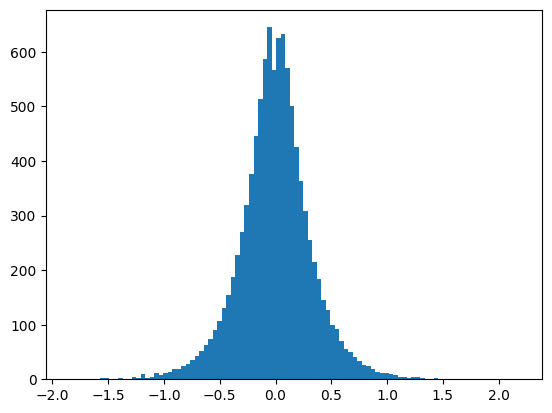

In [6]:
import numpy as np
import random_number_gen
import scipy
import matplotlib.pyplot as plt
gen=random_number_gen.RandomNumberGen()
X=gen.generate_CGMY_Ylessthan1(1000,10,3,5,5,-1.2)
plt.hist(X.flatten(),bins=100)
plt.show()


###Comparing RNGs

In [7]:
class RandomNumberGen():
    def __init__(self,seed):
        self.mod1=2**31-1
        self.a1=0
        self.a2=63308
        self.a3=-183326
        self.mod2=2145483479
        self.b1=86098
        self.b2=0
        self.b3=-539608
        self.x0,self.x1,self.x2=seed


    def Scrambled_Random(self):
        Component1=(self.x2*self.a1+self.x1*self.a2+self.x0*self.a3)%self.mod1
        Component2=(self.x2*self.b1+self.x1*self.b2+self.x0*self.a3)%self.mod2
        Combined=(Component1-Component2)%self.mod1 ##mod1>mod2
        if Combined<0:
            Combined+=self.mod1
        y=Combined
        y^=y<<17


        y^=y>>15


        y^=y<<26

        y=y%self.mod1

        self.x2,self.x1,self.x0=y,self.x2,self.x1

        return y/self.mod1
    def Random(self):
        Component1=(self.x2*self.a1+self.x1*self.a2+self.x0*self.a3)%self.mod1
        Component2=(self.x2*self.b1+self.x1*self.b2+self.x0*self.a3)%self.mod2
        Combined=(Component1-Component2)%self.mod1 ##mod1>mod2
        if Combined<0:
            Combined+=self.mod1
        self.x2,self.x1,self.x0=Combined,self.x2,self.x1
        return Combined/self.mod1
    def LCG(self):
        new=(self.x2*self.a2)%self.mod1
        self.x2=new
        new=new/self.mod1
        return new


In [8]:
import time
import numpy as np
import random_number_gen
RNG2=random_number_gen.RandomNumberGen()
RNG=RandomNumberGen((14,17,27))
start=time.time()
X=np.random.rand(1_000_000)
end=time.time()
print("time taken:",end-start)
start=time.time()
X=[RNG.Scrambled_Random() for _ in range(1_000_000)]
end=time.time()

print("time taken:",end-start)
start=time.time()
X=RNG2.generate_matrix(1_000_000,1)
end=time.time()
print("time taken:",end-start)

time taken: 0.00748753547668457
time taken: 0.9543988704681396
time taken: 0.05953478813171387


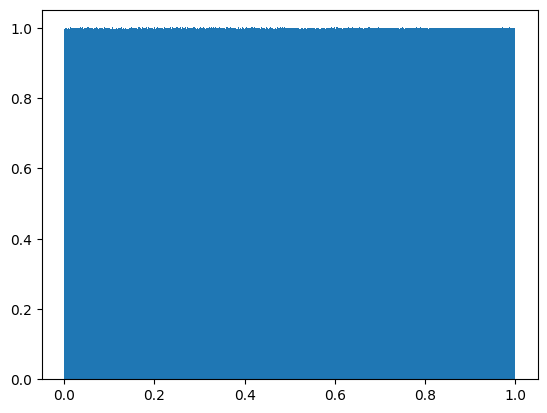

In [9]:
import matplotlib.pyplot as plt
plt.hist(X,bins=2000,density=True)
         
plt.show()


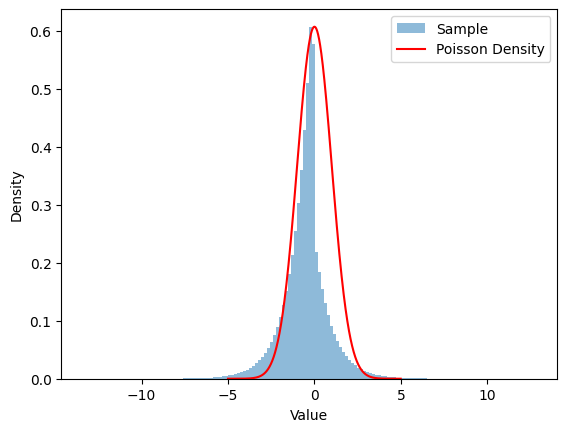

In [10]:
import random_number_gen
gen=random_number_gen.RandomNumberGen()
import numpy as np
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
m=6
sample=gen.generate_double_exponential(1_000_000,1,0.5,1,1)
import matplotlib.pyplot as plt

value,hist,_=plt.hist(sample, bins=150, density=True, alpha=0.5, label='Sample')
x = np.arange(-5, 5,0.01)
pmf = norm.pdf(x)

plt.plot(x, pmf*max(value)/max(pmf), 'r-', label='Poisson Density')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()




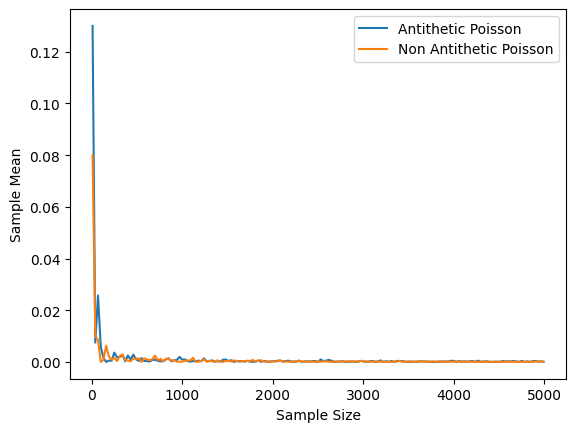

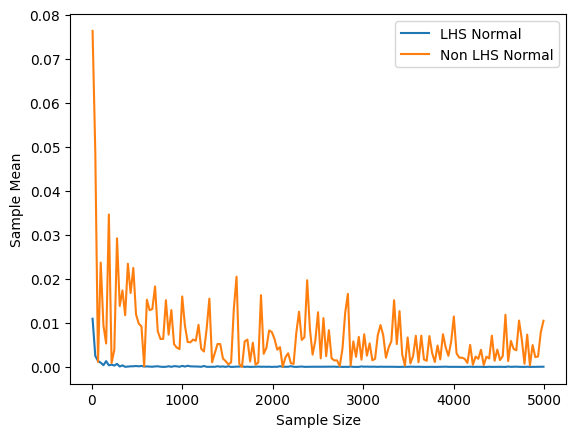

56 ms ± 2.43 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
22.9 ms ± 1.63 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
import numpy as np
from scipy.stats import poisson
import numpy as np
from random_number_gen import RandomNumberGen
from scipy.stats import norm
import matplotlib.pyplot as plt
# Create an instance of RandomNumberGen
rng = RandomNumberGen()
int_range=np.arange(10,5000,30)
# Generate two arrays of Poisson random numbers
A1=[]
A2=[]
for i in int_range:
    poisson1 = rng.generate_poisson(i, 10,5,Antithetic=True) ###Both methods contain LHS so it is not surprising that they are similar in performance
    poisson2 = rng.generate_poisson(i, 10,5,Antithetic=False)
    A1.append(np.abs(np.mean(poisson1)-5))
    A2.append(np.abs(np.mean(poisson2)-5))
plt.plot(int_range,A1,label='Antithetic Poisson')
plt.plot(int_range,A2,label='Non Antithetic Poisson')
plt.xlabel('Sample Size')
plt.ylabel('Sample Mean')
plt.legend()
plt.show()
B1=[]
B2=[]

for i in int_range:
    normal1_sample=rng.generate_matrix(i,10,LHS=True)
    normal2_sample=rng.generate_matrix(i,10,LHS=False)
    normal1=norm.ppf(normal1_sample)
    normal2=norm.ppf(normal2_sample)
    B1.append(np.abs(np.mean(normal1)))
    B2.append(np.abs(np.mean(normal2)))
plt.plot(int_range,B1,label='LHS Normal')
plt.plot(int_range,B2,label='Non LHS Normal')
plt.xlabel('Sample Size')
plt.ylabel('Sample Mean')
plt.legend()
plt.show()
%timeit rng.generate_matrix(1_000_000,1,LHS=True)
%timeit rng.generate_matrix(1_000_000,1,LHS=False)
# Example usage



###CGMY Characteristic function inversion

Fourier Inversion Parameters:###########
alpha: 4.910417579240345
D: 7.04734911563948
L_opt: 34.99999281439142
h: 0.42370244917376193
N: 83.0
eta: 0.08490782067035518


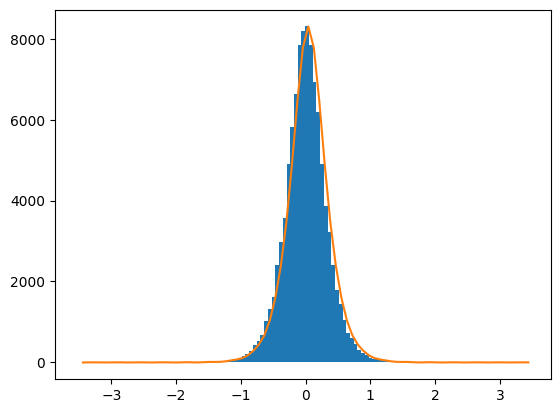

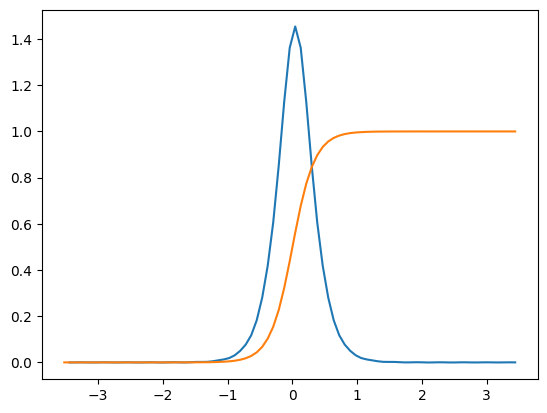

In [12]:

from scipy.special import gamma,gammaincc
import numpy as np
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import scipy
import random_number_gen
  # Rest of the code...
class CGMY():
  def __init__(self, C, G, M, Y, t, error):
    self.C = C
    self.G = G
    self.M = M
    if Y == int(Y):
      self.Y = Y - 0.03  ##to avoid overflow during gamma function evaluation
    else:
      self.Y = Y
    self.t = t
    self.error = error

  def characteristic_function(self,u,t,increment=[0,0,0,0]):

      C,G,M,Y=np.add([self.C,self.G,self.M,self.Y],increment)
      return np.exp(t*C*gamma(-Y)*((M-1j*u)**Y-M**Y+(G+1j*u)**Y-G**Y))

  def calculate_K(self,increment=[0,0,0,0]):
    C,G,M,Y=np.add([self.C,self.G,self.M,self.Y],increment)
    
    return -C*gamma(-Y)*(M**Y+G**Y)

  def reg_characteristic_function(self,u,t):
    if u!=0:
      return -(1-np.cos(u*self.D))/(1j*u)*self.characteristic_function(u,t)
    else:
      return 0

  def L_error(self,L,B,b,beta,D,error):

    Bounderror=D*B/(np.pi*beta*b**(1/beta))*gammaincc(1/beta,b*(L/2)**beta)-error

    return L if Bounderror<0 else np.inf ##if bound is met, return L. Else, return infinity for penalty
  def alpha_minimization(self, alpha):
    t, error = self.t, self.error
    return np.real((2 / alpha) * np.log(
      (self.characteristic_function(1j * alpha, t) + self.characteristic_function(-1j * alpha, t)) / (2 * error / 3)))
  def L_value(self,b):
    res=optimize.minimize_scalar(self.L_error,args=(self.B,b,self.beta,self.D,self.error),bracket=[0, 1000], method='bounded',bounds=(0,35))
    return res.x
  def calculate_zeta(self, alpha):
    C, G, M, Y = self.C, self.G, self.M, self.Y
    term1 = -self.t * C * gamma(-Y) * (G ** Y - (G - alpha) ** Y)
    term2 = -self.t * C * gamma(-Y) * (M ** Y - (M + alpha) ** Y)
    term1 = np.clip(term1, a_min=None, a_max=600)#for numerical stability
    term2 = np.clip(term2, a_min=None, a_max=600)#for numerical stability
    return np.exp(np.logaddexp(term1, term2))

  def calculate_h_from_C(self, C):
    X = self.error * 2 * np.pi / (3 * C)
    return -2 * np.pi * self.alpha / (np.log(X / (1 + X)))
  def calculate_f(self,u,increment=[0,0,0,0]):
    C,G,M,Y=np.add([self.C,self.G,self.M,self.Y],increment)
    part1=(G**2/u**2+1)**(Y/2)*np.cos(Y*np.arctan(u/G))
    part2=(M**2/u**2+1)**(Y/2)*np.cos(Y*np.arctan(u/M))
    return gamma(-Y)*(part1+part2)
  def abs_char(self,u,alpha):
    return np.exp(self.t*self.K+self.t*self.C*np.abs(u)**self.Y*self.calculate_f(u,[0,-alpha,alpha,0]))


  def calculate_bound_A_integrals(self, alpha, u_star):
    """
    Calculates the bound A integrals for a given alpha and u_star.

    Parameters:
    alpha (float): The alpha value.
    u_star (float): The u_star value.

    Returns:
    float: The calculated bound A value.
    """
    stand_incr = [0, -alpha, alpha, 0]
    ##for calculating positive alpha integrals and zeta
    pos_alpha_K = self.calculate_K(increment=stand_incr)

    pos_alpha_int = scipy.integrate.quad(lambda x: self.abs_char(x,alpha),10e-10,u_star)[0]

    pos_alpha_upp = np.exp(self.t * pos_alpha_K) / (self.beta * self.b ** (1 / self.beta)) * gammaincc(1 / self.beta,
                self.b * u_star ** self.beta)
    
    pos_alpha_all_int = self.calculate_zeta(alpha) * (pos_alpha_int + pos_alpha_upp)
    ##for calculating negative alpha integrals and zeta
    neg_incr = [0, alpha, -alpha, 0]
    
    neg_alpha_K = self.calculate_K(increment=neg_incr)

    neg_alpha_int = scipy.integrate.quad(lambda x: self.abs_char(x,-alpha),10e-10,u_star)[0]
    
    neg_alpha_upp = np.exp(self.t * neg_alpha_K) / (self.beta * self.b ** (1 / self.beta)) * gammaincc(1 / self.beta,
                   self.b * u_star ** self.beta)

    neg_alpha_all_int = self.calculate_zeta(-alpha) * (neg_alpha_int + neg_alpha_upp)

    
    all_int = pos_alpha_all_int + neg_alpha_all_int+10e-9 #for numerical stability

    #for numerical stability
    part1 = np.exp(np.clip(((-self.D * self.alpha / 2+2*(self.D * self.alpha))), a_min=None, a_max=600))

    part2 = 2 * np.exp(np.clip((-self.D * self.alpha / 2+ self.D * self.alpha), a_min=None, a_max=600))
    part3 = np.exp(-self.D * self.alpha / 2)
    
    A = 1 / self.alpha * (part1+part2+part3) + all_int
    return A 

  def generate_cdf(self):
    """
    Generate the cumulative distribution function (CDF) for the Jump Diffusion Model.

    Parameters:
    

    Returns:
    - x_range (numpy.ndarray): An array of x values.
    - M (numpy.ndarray): An array of real values representing the CDF.

    """
    t=self.t
    ##Regularization error
    alpha_bounds = (0, np.min([self.G, self.M]))
    optimization = optimize.minimize_scalar(self.alpha_minimization, 1, bounds=alpha_bounds)
    self.alpha = optimization.x
    print("Fourier Inversion Parameters:###########")
    print("alpha:", self.alpha)
    self.D = optimization.fun
    print("D:", self.D)
    ##Truncating error
    self.K = self.calculate_K()
    K=self.K
    self.beta = self.Y
    self.B = np.exp(t * K)

    if self.Y > 1:
      u_star = max(self.G, self.M) * max(np.tan(np.pi / (2 * self.Y)), -1 / np.tan(self.Y * np.pi / 2))

      self.b = -t * self.C * self.calculate_f(np.ceil(u_star))
      C = self.calculate_bound_A_integrals(self.alpha, u_star)

      h=self.calculate_h_from_C(C)
      L_opt = max(self.L_value(self.b), np.ceil(u_star))
     
    elif self.Y > 0:
      b = -t * 2 * self.C * gamma(-self.Y) * np.cos(np.pi * self.Y / 2)
      L_opt = self.L_value(b)
      A = (2 * np.exp(-self.D * self.alpha / 2) * (np.exp(self.D * self.alpha) + 1) ** 2 * self.B * gamma(
        1 / self.beta)) / (self.alpha * self.beta * b ** (1 / self.beta))

      h=self.calculate_h_from_C(A)
    print("L_opt:", L_opt)
    print("h:", h)

    N = np.ceil(L_opt / h)
    print("N:", N)
    eta = self.D / N
    print(  "eta:", eta)





    ###Vectorized Operations for faster computation
 
    u_domain = np.arange(-N/2*h, (N/2)*h, h)
    x_range = np.arange(-N/2*eta, (N/2)*eta, eta)

    const = 1/(2*np.pi) * h

    
    reg_char_func_vect = np.vectorize(lambda u: self.reg_characteristic_function(u, t))

    # Computing the characteristic values for each u in u_domain
    characteristic_values = reg_char_func_vect(u_domain)

    # Pre-compute the exponential part using broadcasting
    # np.outer effectively creates a matrix where each row corresponds to an element in u_domain and each column to an element in x_range
    exp_matrix = np.exp(-1j * np.outer(u_domain, x_range))

    # Element-wise multiplication of exp_matrix with characteristic_values (reshaped for broadcasting)
    vect = exp_matrix * characteristic_values[:, np.newaxis]

    # Compute results by integrating (summing) over the u_domain for each x_range index
    res = const * vect
    real_res = np.sum(res, axis=0)  # Summing along the 'u_domain' axis

    M2 = real_res  # M contains the real parts of the computed values for each x_range index
    
    M2+=np.ones(len(M2))*0.5
    
    return x_range,np.real(M2)

# Test the code
cgmy = CGMY(C=240 , G=5, M=5, Y=0.5, t=1/365, error=10e-7)

C=cgmy.generate_cdf()
sample_gen=random_number_gen.RandomNumberGen()
sample_gen.inverse_transform(sample_gen.generate_matrix(100000,1),C[1],C[0])
hist_values,bins,_=plt.hist(sample_gen.inverse_transform(sample_gen.generate_matrix(100000,1),C[1],C[0]),bins=100)
Dx=C[0][1]-C[0][0]
D=np.diff(C[1])/Dx

plt.plot(C[0][1:],D*max(hist_values)/max(D))
plt.show()

plt.plot(C[0][1:],D)
plt.plot(C[0],C[1])

plt.show()

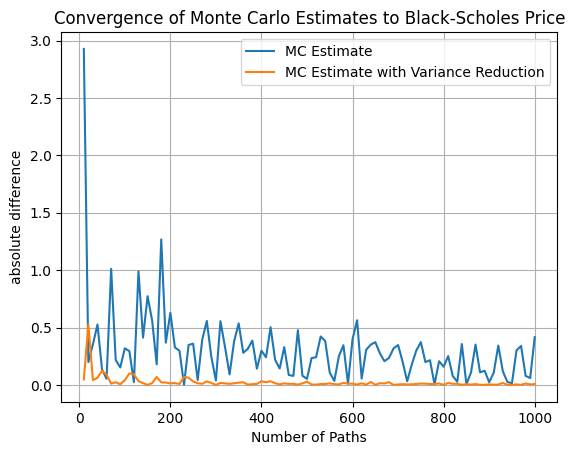

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import random_number_gen
gen=random_number_gen.RandomNumberGen()
def black_scholes_call(S, K, T, r, sigma):
    """Calculate the Black-Scholes price of a European call option."""
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

def monte_carlo_call(S, K, T, r, sigma, paths):
    """Monte Carlo simulation for the European call option price."""
    dt = T
    # Simulating the end stock price
    ST = S * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * norm.ppf(np.array(gen.generate_matrix(paths,4,LHS=False)) ) )
    # Calculating the payoff
    payoffs = np.maximum(ST - K, 0)
    # Discounting the payoff back to present value
    call_price_mc = np.exp(-r * T) * np.mean(payoffs)
    return call_price_mc
def monte_carlo_call_antithetic(S, K, T, r, sigma, paths):
    """Monte Carlo simulation for the European call option price."""
    dt = T
    # Simulating the end stock price
    sample=norm.ppf(np.array(gen.generate_matrix(paths//2,4,LHS=True)) )
    #np.random.standard_normal(paths//2)
    sample=np.concatenate([sample,-sample])
    ST = S * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * sample)
    # Calculating the payoff
    payoffs = np.maximum(ST - K, 0)
    # Discounting the payoff back to present value
    call_price_mc = np.exp(-r * T) * np.mean(payoffs)
    
    return call_price_mc

def plot_convergence(S, K, T, r, sigma, max_paths, step,plot=False):
    """Plot the convergence of the Monte Carlo simulation to the Black-Scholes price."""
    bs_price = black_scholes_call(S, K, T, r, sigma)
    paths_range = np.arange(step, max_paths + step, step)
    mc_prices = []

    for num_paths in paths_range:
        mc_price = monte_carlo_call(S, K, T, r, sigma, num_paths)
        mc_prices.append(mc_price)

    diff=np.abs(mc_prices-bs_price*np.ones(len(mc_prices)))
    if plot:
        plt.plot(paths_range, diff, label='MC Estimate')
    

def plot_convergence_antithetic(S, K, T, r, sigma, max_paths, step,plot=False):
    """Plot the convergence of the Monte Carlo simulation to the Black-Scholes price."""
    bs_price = black_scholes_call(S, K, T, r, sigma)
    paths_range = np.arange(step, max_paths + step, step)
    mc_prices = []

    for num_paths in paths_range:
        mc_price = monte_carlo_call_antithetic(S, K, T, r, sigma, num_paths)
        mc_prices.append(mc_price)

    diff=np.abs(mc_prices-bs_price*np.ones(len(mc_prices)))
    if plot:
        plt.plot(paths_range, diff, label='MC Estimate with Variance Reduction')
    # plt.plot(paths_range, diff, label='MC Estimate Antithetic')

        plt.xlabel('Number of Paths')
        plt.ylabel('absolute difference')
        plt.title('Convergence of Monte Carlo Estimates to Black-Scholes Price')
        plt.legend()
        plt.grid(True)
        plt.show()

# Example parameters
S = 100  # Stock price
K = 100  # Strike price
T = 1    # Time to expiration in years
r = 0.05 # Risk-free rate
sigma = 0.2  # Volatility

# Uncomment below line to execute the plotting function
# %timeit plot_convergence(S, K, T, r, sigma, 100000, 100)
# %timeit plot_convergence_antithetic(S, K, T, r, sigma, 100000, 100)
plot_convergence(S, K, T, r, sigma, 1000, 10,plot=True)
plot_convergence_antithetic(S, K, T, r, sigma, 1000, 10,plot=True)

####Model implementation

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy
import math
import random_number_gen
import scipy.optimize as optimize
gen=random_number_gen.RandomNumberGen()
from scipy.special import gamma,gammaincc,gammainc,gammaincinv,gammainccinv
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, message="Conversion of an array with ndim > 0 to a scalar is deprecated")


In [15]:
class Merton():
    def __init__(self,mu,sigma,lambda_,muJ,sigmaJ):
        self.mu=mu
        self.sigma=sigma
        self.lambda_=lambda_
        self.muJ=muJ
        self.sigma_J=sigmaJ
    def simulate_end(self,paths,T,S0=100):
        S=S0*np.exp((self.mu-self.sigma**2/2)*T )
        poisson_sample=gen.generate_poisson(paths,1,self.lambda_*T)
        normal_sample=gen.generate_normal(paths,1)
        max_poisson=np.max(poisson_sample)
        jump_sample=gen.generate_normal(paths,max_poisson,self.muJ,self.sigma_J)
        #%timeit np.array([np.concatenate([np.ones(int(x)),np.zeros(int(max_poisson-x))]) for x in poisson_sample])
        #out = np.array([np.pad(np.ones(int(x)), (0, int(max_poisson - x)), 'constant', constant_values=0) for x in poisson_sample])
        out=np.array([np.concatenate([np.ones(int(x)),np.zeros(int(max_poisson-x))]) for x in poisson_sample])
        #%timeit np.sum(np.where(out==1,jump_sample,np.zeros((n,int(max_poisson)))),axis=1) ##matrix of 1s and 0s where the sum of each row is equal to the poisson var
        jump_vect=np.sum(np.where(out==1,jump_sample,np.zeros((paths,int(max_poisson)))),axis=1)[:,np.newaxis]
        #print((self.sigma*math.sqrt(T)*normal_sample).shape)
        S=S*np.exp(self.sigma*math.sqrt(T)*normal_sample)*np.exp(jump_vect)
        #print(jump_vect.shape)
        #print(S.shape)
        return S
    def simulate_paths(self,paths,T,N,S0=100):
        dt=T/N
        S=S0*np.ones((paths,N))
        const=np.exp((self.mu-self.sigma**2/2)*dt )
        poisson_sample=gen.generate_poisson(paths,N,self.lambda_*dt)
        normal_sample=gen.generate_normal(paths,N)
        
        for l in range(1,N):
            max_poisson=np.max(poisson_sample[:,l])
            jump_sample=gen.generate_normal(paths,max_poisson,self.muJ,self.sigma_J)
            out=np.array([np.concatenate([np.ones(int(x)),np.zeros(int(max_poisson-x))]) for x in poisson_sample[:,l]])
            
            S[:,l]=S[:,l-1]*const*np.exp(self.sigma*math.sqrt(T)*normal_sample[:,l])*np.exp(np.sum(np.where(out==1,jump_sample,np.zeros((paths,int(max_poisson)))),axis=1))
        
        return S
    def update_params(self,params):
        self.mu,self.sigma,self.lambda_,self.muJ,self.sigma_J=params
    def update_time(self,T):
        pass
    def prior(self):
        mu = np.random.uniform(-0.4, 0.4)  # Uniform prior for mu
        sigma = np.random.uniform(0.05, 0.35)  # Uniform prior for sigma
        lambda_ = np.random.uniform(0, 0.1)  # Uniform prior for lambda
        muJ = np.random.uniform(-0.4, 0.4)  # Uniform prior for muJ
        sigmaJ = np.random.uniform(0, 0.8)
        
        return [mu,abs(sigma),abs(lambda_),muJ,abs(sigmaJ)]

X=Merton(0.05,0.1,0.01,-0.05,0.1)



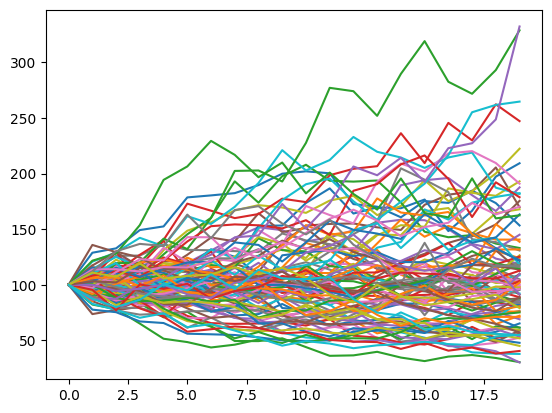

In [16]:
class Kou():
    def __init__(self,mu,sigma,lambda_,p,eta1,eta2):
        self.mu=mu
        self.sigma=sigma
        self.lambda_=lambda_
        self.p=p
        self.eta1=eta1
        self.eta2=eta2
    def simulate_end(self,paths,T,S0=100):
        S=S0*np.exp((self.mu-self.sigma**2/2)*T )
        poisson_sample=gen.generate_poisson(paths,1,self.lambda_*T)
        normal_sample=gen.generate_normal(paths,1)
        max_poisson=np.max(poisson_sample)
        jump_sample=gen.generate_double_exponential(paths,max_poisson,self.p,self.eta1,self.eta2)
        out=np.array([np.concatenate([np.ones(int(x)),np.zeros(int(max_poisson-x))]) for x in poisson_sample])
        jump_vect=np.sum(np.where(out==1,jump_sample,np.zeros((paths,int(max_poisson)))),axis=1)[:,np.newaxis]
        S=S*np.exp(self.sigma*math.sqrt(T)*normal_sample)*np.exp(jump_vect)
        return S
    def update_time(self,t):
        pass
    def update_params(self,params):
        self.mu,self.sigma,self.lambda_,self.p,self.eta1,self.eta2=params
    
    def simulate_paths(self,paths,T,N,S0=100):
        dt=T/N
        S=S0*np.ones((paths,N))
        const=np.exp((self.mu-self.sigma**2/2)*dt )
        poisson_sample=gen.generate_poisson(paths,N,self.lambda_*dt)
        normal_sample=gen.generate_normal(paths,N)
        
        for l in np.arange(1,int(N)):
            max_poisson=np.max(poisson_sample[:,l])
            jump_sample=gen.generate_double_exponential(paths,max_poisson,self.p,self.eta1,self.eta2)
            out=np.array([np.concatenate([np.ones(int(x)),np.zeros(int(max_poisson-x))]) for x in poisson_sample[:,l]])
            
            S[:,l]=S[:,l-1]*np.exp(self.sigma*math.sqrt(T)*normal_sample[:,l])*np.exp(np.sum(np.where(out==1,jump_sample,np.zeros((paths,int(max_poisson)))),axis=1))
        
        return S
    def update_params(self,params):
        self.mu,self.sigma,self.lambda_,self.p,self.eta1,self.eta2=params
    def prior(self):##for Parameter Estimation later
        
        mu=np.random.uniform(-0.4,0.4)
        sigma=np.random.uniform(0.05,0.35)
        lambda_=np.random.uniform(0,0.1)
        p=np.random.uniform(0,1)
        eta1=np.random.uniform(0,5)
        eta2=np.random.uniform(0,5)
                             
        return [mu,abs(sigma),abs(lambda_),p,eta1,eta2]


X=Kou(0.05,0.1,0.01,0.5,0.1,0.1)
S=X.simulate_paths(100,1,20)
plt.plot(S.transpose())
plt.show()

In [17]:
class CGMY():
  def __init__(self,C,G,M,Y,eta,mu):
      self.C=C
      self.G=G
      self.M=M
      if np.abs(Y-int(Y))<0.05:
        Y-=0.05
      self.Y=Y
      self.eta=eta
      self.generated=False
      self.mu=mu
  
  def characteristic_function(self,u,t,increment=[0,0,0,0]):

    C,G,M,Y=np.add([self.C,self.G,self.M,self.Y],increment)
    return np.exp(t*C*gamma(-Y)*((M-1j*u)**Y-M**Y+(G+1j*u)**Y-G**Y))

  def calculate_K(self,increment=[0,0,0,0]):
    C,G,M,Y=np.add([self.C,self.G,self.M,self.Y],increment)
    
    return -C*gamma(-Y)*(M**Y+G**Y)

  def reg_characteristic_function(self,u,t):
    if u!=0:
      return -(1-np.cos(u*self.D))/(1j*u)*self.characteristic_function(u,t)
    else:
      return 0

  def L_error(self,L,B,b,beta,D,error):

    Bounderror=D*B/(np.pi*beta*b**(1/beta))*gammaincc(1/beta,b*(L/2)**beta)-error

    return L if Bounderror<0 else np.inf ##if bound is met, return L. Else, return infinity for penalty
  def alpha_minimization(self, alpha):
    t, error = self.t, self.error
    return np.real((2 / alpha) * np.log(
      (self.characteristic_function(1j * alpha, t) + self.characteristic_function(-1j * alpha, t)) / (2 * error / 3)))
  def L_value(self,b):
    res=optimize.minimize_scalar(self.L_error,args=(self.B,b,self.beta,self.D,self.error),bracket=[0, 1000], method='bounded',bounds=(0,35))
    return res.x
  def calculate_zeta(self, alpha):
    C, G, M, Y = self.C, self.G, self.M, self.Y
    term1 = -self.t * C * gamma(-Y) * (G ** Y - (G - alpha) ** Y)
    term2 = -self.t * C * gamma(-Y) * (M ** Y - (M + alpha) ** Y)
    term1 = np.clip(term1, a_min=None, a_max=600)#for numerical stability
    term2 = np.clip(term2, a_min=None, a_max=600)#for numerical stability
    return np.exp(np.logaddexp(term1, term2))

  def calculate_h_from_C(self, C):
    X = self.error * 2 * np.pi / (3 * C)
    return -2 * np.pi * self.alpha / (np.log(X / (1 + X)))
  def calculate_f(self,u,increment=[0,0,0,0]):
    C,G,M,Y=np.add([self.C,self.G,self.M,self.Y],increment)
    part1=(G**2/u**2+1)**(Y/2)*np.cos(Y*np.arctan(u/G))
    part2=(M**2/u**2+1)**(Y/2)*np.cos(Y*np.arctan(u/M))
    return gamma(-Y)*(part1+part2)
  def abs_char(self,u,alpha):
    return np.exp(self.t*self.K+self.t*self.C*np.abs(u)**self.Y*self.calculate_f(u,[0,-alpha,alpha,0]))


  def calculate_bound_A_integrals(self, alpha, u_star):
    """
    Calculates the bound A integrals for a given alpha and u_star.

    Parameters:
    alpha (float): The alpha value.
    u_star (float): The u_star value.

    Returns:
    float: The calculated bound A value.
    """
    stand_incr = [0, -alpha, alpha, 0]
    ##for calculating positive alpha integrals and zeta
    pos_alpha_K = self.calculate_K(increment=stand_incr)

    pos_alpha_int = scipy.integrate.quad(lambda x: self.abs_char(x,alpha),10e-10,u_star)[0]

    pos_alpha_upp = np.exp(self.t * pos_alpha_K) / (self.beta * self.b ** (1 / self.beta)) * gammaincc(1 / self.beta,
                self.b * u_star ** self.beta)
    
    pos_alpha_all_int = self.calculate_zeta(alpha) * (pos_alpha_int + pos_alpha_upp)
    ##for calculating negative alpha integrals and zeta
    neg_incr = [0, alpha, -alpha, 0]
    
    neg_alpha_K = self.calculate_K(increment=neg_incr)

    neg_alpha_int = scipy.integrate.quad(lambda x: self.abs_char(x,-alpha),10e-10,u_star)[0]
    
    neg_alpha_upp = np.exp(self.t * neg_alpha_K) / (self.beta * self.b ** (1 / self.beta)) * gammaincc(1 / self.beta,
                   self.b * u_star ** self.beta)

    neg_alpha_all_int = self.calculate_zeta(-alpha) * (neg_alpha_int + neg_alpha_upp)

    
    all_int = pos_alpha_all_int + neg_alpha_all_int+10e-9 #for numerical stability

    #for numerical stability
    part1 = np.exp(np.clip(((-self.D * self.alpha / 2+2*(self.D * self.alpha))), a_min=None, a_max=600))

    part2 = 2 * np.exp(np.clip((-self.D * self.alpha / 2+ self.D * self.alpha), a_min=None, a_max=600))
    part3 = np.exp(-self.D * self.alpha / 2)
    
    A = 1 / self.alpha * (part1+part2+part3) + all_int
    return A 

  def generate_cdf(self):
    """
    Generate the cumulative distribution function (CDF) for the Jump Diffusion Model.

    Parameters:
    

    Returns:
    - x_range (numpy.ndarray): An array of x values.
    - M (numpy.ndarray): An array of real values representing the CDF.

    """
    t=self.t
    ##Regularization error
    alpha_bounds = (0, np.min([self.G, self.M]))
    optimization = optimize.minimize_scalar(self.alpha_minimization, 1, bounds=alpha_bounds)
    self.alpha = optimization.x
    #print("Fourier Inversion Parameters:###########")
    #print("alpha:", self.alpha)
    self.D = optimization.fun
    #print("D:", self.D)
    ##Truncating error
    self.K = self.calculate_K()
    K=self.K
    self.beta = self.Y
    self.B = np.exp(t * K)

    if self.Y > 1:
      u_star = max(self.G, self.M) * max(np.tan(np.pi / (2 * self.Y)), -1 / np.tan(self.Y * np.pi / 2))

      self.b = -t * self.C * self.calculate_f(np.ceil(u_star))
      C = self.calculate_bound_A_integrals(self.alpha, u_star)

      h=self.calculate_h_from_C(C)
      L_opt = max(self.L_value(self.b), np.ceil(u_star))
     
    elif self.Y > 0:
      b = -t * 2 * self.C * gamma(-self.Y) * np.cos(np.pi * self.Y / 2)
      L_opt = self.L_value(b)
      A = (2 * np.exp(-self.D * self.alpha / 2) * (np.exp(self.D * self.alpha) + 1) ** 2 * self.B * gamma(
        1 / self.beta)) / (self.alpha * self.beta * b ** (1 / self.beta))

      h=self.calculate_h_from_C(A)
    #print("L_opt:", L_opt)
    #print("h:", h)

    N = np.ceil(L_opt / h)
    #print("N:", N)
    eta = self.D / N
    #print(  "eta:", eta)





    ###Vectorized Operations for faster computation
 
    u_domain = np.arange(-N/2*h, (N/2)*h, h)
    x_range = np.arange(-N/2*eta, (N/2)*eta, eta)

    const = 1/(2*np.pi) * h

    
    reg_char_func_vect = np.vectorize(lambda u: self.reg_characteristic_function(u, t))

    # Computing the characteristic values for each u in u_domain
    characteristic_values = reg_char_func_vect(u_domain)

    # Pre-compute the exponential part using broadcasting
    # np.outer effectively creates a matrix where each row corresponds to an element in u_domain and each column to an element in x_range
    exp_matrix = np.exp(-1j * np.outer(u_domain, x_range))

    # Element-wise multiplication of exp_matrix with characteristic_values (reshaped for broadcasting)
    vect = exp_matrix * characteristic_values[:, np.newaxis]

    # Compute results by integrating (summing) over the u_domain for each x_range index
    res = const * vect
    real_res = np.sum(res, axis=0)  # Summing along the 'u_domain' axis

    M2 = real_res  # M contains the real parts of the computed values for each x_range index
    
    M2+=np.ones(len(M2))*0.5
    self.generated=True
    self.CumDensity=(x_range,np.real(M2))
    return x_range,np.real(M2)
  
    
  def generate_inverse_transform_sample(self,n,rows):
    if not self.generated:
      self.generate_cdf()
    return gen.inverse_transform(gen.generate_matrix(n,rows),self.CumDensity[1],self.CumDensity[0])
  def generate_sample(self,n,rows,t,error):
    self.t=t
    self.error=error
    if self.Y>0:
      out=self.generate_inverse_transform_sample(n,rows)
    else:
      out=gen.generate_CGMY_Ylessthan1(n,rows,self.C,self.G,self.M,self.Y)
    return out
  def update_params(self,params):
    self.C,self.G,self.M,self.Y,self.eta=params
    self.generated=False
  def update_time(self,t):
    self.t=t
    self.generated=False
  def calculate_omega(self):
    omega=-np.log(self.characteristic_function(-1j,self.t))/self.t
    return omega
  def simulate_end(self,paths,T,s0,error=10e-15):
    S=s0
    cgmy_sample=np.real(self.generate_sample(paths,1,T,error))
    omega=self.calculate_omega()
   
    S=np.exp((self.mu+omega-self.eta**2/2))*S
    normal_sample=gen.generate_normal(paths,1)
 
    S=S*np.exp(np.sqrt(T)*cgmy_sample)
   
    S=S*np.exp(self.eta*np.sqrt(T)*normal_sample)
    
    return np.real(S)
  def simulate_paths(self,paths,N,T,s0,error):
    dt=T/N
    S=s0*np.ones((paths,N))
    cgmy_sample=self.generate_sample(paths,N,dt,error)
    omega=self.calculate_omega()
    S=np.exp((self.mu+omega-self.eta**2/2))*S
    normal_sample=gen.generate_normal(paths,N)
    for l in range(1,N):
        S[:,l]=S[:,l-1]*np.exp(cgmy_sample[:,l]+self.eta*np.sqrt(dt)*normal_sample[:,l])
    return np.real(S)

  
X=CGMY(2,12,12,-0.6,0.04,0.05)




###Downloading the Data

In [18]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import datetime
from scipy.special import gamma,gammaincc,gammainc,gammaincinv,gammainccinv

In [19]:
__TICKERS_TO_CHECK=["TSLA","AAPL","MSFT"]

In [20]:
class Download_data():
    def __init__(self,tickers):
        self.tickers=tickers
        self.columns_to_keep=["contractSymbol",	"strike","volume",	"lastPrice",	"impliedVolatility",	"currency"]
    def download_data(self,ticker,period):
        data=yf.download(ticker,period=period)
        data.log_price=np.diff(np.log(data["Adj Close"]))
        pd.DataFrame(data.log_price).to_csv(f"{ticker}.csv")
        return {datetime.datetime.today().strftime('%Y-%m-%d'):ticker}
    def get_option_chain(self,ticker,nb_strikes,nb_exp):
        YFTICKER=yf.Ticker(ticker)
        option_chain=YFTICKER.option_chain()
        current_price=YFTICKER.history(period="1d")["Close"][0]
       
        
        exp=list(YFTICKER._expirations.keys())[0:nb_exp]
        
        output=pd.DataFrame()
        for l in exp:
            
            temp_option_chain=YFTICKER.option_chain(l)
            all_options=temp_option_chain.calls._append(temp_option_chain.puts)
            delta=np.sort(np.abs(np.diff(all_options["strike"])))[0]
            
            all_options=all_options[all_options["strike"].between(current_price-delta*nb_strikes,current_price+delta*nb_strikes)]
            all_options=all_options[self.columns_to_keep]
            output=pd.concat([output,all_options],ignore_index=True)
        output.to_csv(f"{ticker}_option_chain.csv")
        return {datetime.datetime.today().strftime('%Y-%m-%d'):ticker}
    def get_data(self):
        output={}
        for l in self.tickers:
            try:
                pd.read_csv(f"{l}.csv")
                import os
                import datetime

                

                # Get the modification time of the file
                file_time = os.path.getmtime(f"{l}.csv")

                # Convert the modification time to a datetime object
                file_date = datetime.datetime.fromtimestamp(file_time).date()

                # Get today's date
                today = datetime.date.today()

                # Compare the file date with today's date
                if file_date == today:
                    print("The time from the asset return file matches today's date.")
                else:
                    print("The time from the asset return file does not match today's date.")
                    output.update(self.download_data(l,"1y"))
            except:
                output.update(self.download_data(l,"1y"))
            try:
                pd.read_csv(f"{l}_option_chain.csv")
                import os
                import datetime

                

                # Get the modification time of the file
                file_time = os.path.getmtime(f"{l}_option_chain.csv")

                # Convert the modification time to a datetime object
                file_date = datetime.datetime.fromtimestamp(file_time).date()

                # Get today's date
                today = datetime.date.today()

                # Compare the file date with today's date
                if file_date == today:
                    print("The time from the option chain file matches today's date.")
                else:
                    print("The time from the option chain file does not match today's date.")
                    output.update(self.get_option_chain(l,5,5))
            except:
                output.update(self.get_option_chain(l,5,5))
        
        return output

x=Download_data(__TICKERS_TO_CHECK)
x.get_data()

The time from the asset return file does not match today's date.


[*********************100%%**********************]  1 of 1 completed
C:\Users\Bram\AppData\Local\Temp\ipykernel_28728\3990691205.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  data.log_price=np.diff(np.log(data["Adj Close"]))


The time from the option chain file does not match today's date.


C:\Users\Bram\AppData\Local\Temp\ipykernel_28728\3990691205.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current_price=YFTICKER.history(period="1d")["Close"][0]


The time from the asset return file does not match today's date.


[*********************100%%**********************]  1 of 1 completed
C:\Users\Bram\AppData\Local\Temp\ipykernel_28728\3990691205.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  data.log_price=np.diff(np.log(data["Adj Close"]))


The time from the option chain file does not match today's date.


C:\Users\Bram\AppData\Local\Temp\ipykernel_28728\3990691205.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current_price=YFTICKER.history(period="1d")["Close"][0]
[*********************100%%**********************]  1 of 1 completed

The time from the asset return file does not match today's date.
The time from the option chain file does not match today's date.



C:\Users\Bram\AppData\Local\Temp\ipykernel_28728\3990691205.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  data.log_price=np.diff(np.log(data["Adj Close"]))
C:\Users\Bram\AppData\Local\Temp\ipykernel_28728\3990691205.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current_price=YFTICKER.history(period="1d")["Close"][0]


{'2024-05-21': 'MSFT'}

###Calculating Option Prices:

In [50]:
class Option_Price_Calculator():
    def __init__(self):
        self.discount_rate=0.05
        pass
    def transform_into_df(self,option_names):
        ext=option_names.str.extract(r'(\D{4})(\d{6})(\D)(\d+)', expand=True)
        ext.columns=["Ticker","Date","Type","Strike"]
        
        
        ext.Date=pd.to_datetime(ext.Date,format="%y%m%d")
        ext.Strike=ext.Strike.astype(float)/1000
        out=pd.concat([option_names,ext],axis=1)
        out.columns=["Option","Ticker","Date","Type","Strike"]
        return out
    def price_options(self,option_chain,s0,nb_simulations,model):
        X=self.transform_into_df(option_chain["contractSymbol"])
        all_sims=pd.DataFrame()
        
        X["Sim_price"]=np.nan
        for l in X.Date.unique():
            
            time_to_exp=((l-pd.Timestamp.today()).days+1)/365
            model.update_time(time_to_exp)
            
            sim=np.real(model.simulate_end(nb_simulations,time_to_exp,s0))
            
            sim=pd.DataFrame(sim,columns=[datetime.datetime.strftime(l,"%Y-%m-%d")])
            all_sims=pd.concat([all_sims,pd.DataFrame(sim)],axis=1)
        
        for i,j in enumerate(X.Date):
            Delay=(j-pd.Timestamp.today()).days/365
            index=datetime.datetime.strftime(j,"%Y-%m-%d")
            
            exp_S=s0*np.exp(Delay*self.discount_rate)
            
            sim_prices=all_sims[index]
            if X.Type[i]=="C":
                Exp_price=np.maximum(sim_prices-X.Strike[i],0)
                
            else:
                Exp_price=np.maximum(X.Strike[i]-sim_prices,0)
            
            

            b_hat=np.cov(sim_prices,Exp_price)[0,1]/np.var(sim_prices)
            
            
            Control_Var_adj=Exp_price-b_hat*(all_sims[index]-exp_S)
            
            X.loc[i,"Sim_price"]=max(np.exp(-Delay*self.discount_rate)*np.mean(Control_Var_adj),0)
        return X
    def Option_error(self,option_chain,s0,nb_simulations,model,metric="MAE"):
        X=self.price_options(option_chain,s0,nb_simulations,model)
        
        if metric=="MAE":
            return np.mean(np.abs(option_chain.lastPrice-X.Sim_price))
        elif metric=="MSE":
            return np.mean((option_chain.lastPrice-X.Sim_price)**2)
        return X
    def error_vector(self,option_chain,s0,nb_simulations,model,metric="MAE"):
        X=self.price_options(option_chain,s0,nb_simulations,model)
        return np.abs(option_chain.lastPrice-X.Sim_price)
    def plot_option_prices(self, option_chain, s0, nb_simulations, model):
        X = self.price_options(option_chain, s0, nb_simulations, model)
        
        # Plot actual prices vs. simulated prices
        plt.figure(figsize=(14, 8))
        
        for date in X.Date.unique():
    subset = X[X.Date == date]
    subset = subset[subset.Type == "C"]
    random_market_color = "#" + ''.join([np.random.choice(list('0123456789ABCDEF')) for j in range(6)])
    random_simulated_color = "#" + ''.join([np.random.choice(list('0123456789ABCDEF')) for j in range(6)])

    # Plotting with lines connecting the points
    plt.plot(subset.Strike, subset.Sim_price, color=random_market_color, label=f"Simulated {date.date()}", marker='o', linestyle='-')
    plt.plot(subset.Strike, option_chain[option_chain['contractSymbol'].isin(subset.Option)].lastPrice, color=random_simulated_color, label=f"Actual {date.date()}", marker='x', linestyle='-')

plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.title('Simulated Option Prices vs Actual Prices')
plt.legend()
plt.grid(True)
plt.show()
p=Option_Price_Calculator()
#print(p.Option_error(pd.read_csv("AAPL_option_chain.csv"),180,1000,CGMY(5,12,12,-0.6,0.04,0.05)))
#Price=p.price_options(pd.read_csv("AAPL_option_chain.csv"),180,1000,CGMY(5,12,12,-0.6,0.04,0.05))


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import scipy.stats as stats


class RandomWalkMetropolisHastings:
    def __init__(self, initial_state, proposal_params, data, model,limits,special=0):
        self.state = initial_state
        self.proposal_params = proposal_params
        self.data = data["0"]
        self.model = model
        self.accepted = 0
        self.rejected = 0
        self.likelihoods = []
        self.log_like=-np.inf
        self.min=limits[:,0]
        self.max=limits[:,1]
        self.special=special
        self.lambda_=0.1
        self.max_likelihood=-np.inf
        self.max_state=initial_state
        

    def step(self):
        
        proposed_state = self.proposal_distribution(self.state, self.proposal_params)
        if not( np.all((proposed_state >= self.min) & (proposed_state <= self.max))):
            return self.state
        try:
            new_ll = self.log_likelihood(proposed_state)#+np.log(self.model.prior(proposed_state))
        except RuntimeWarning as e:
            new_ll = -50
        except RuntimeError as e:
            new_ll = -50
        
        current_ll = self.log_like#+np.log(self.model.prior(self.state))
        if new_ll>self.max_likelihood:
            self.max_likelihood=new_ll
            self.max_state=proposed_state
        log_alpha = new_ll - current_ll

        if np.log(gen.Scrambled_Random()) < log_alpha:
            self.state = proposed_state
            self.accepted += 1
            self.log_like = new_ll 
            self.likelihoods.append(new_ll)
        else:
            self.rejected += 1
            self.likelihoods.append(current_ll)  

        return self.state
    def reset_acceptance(self):
        self.accepted=0
        self.rejected=0
        
    def run(self, n):
        stop=False
        k=0
        while True:
            k+=1
            self.step()
            if k % 100 == 0:
                #print(f"Step {k}, Acceptance Rate: {self.acceptance_rate():.2f}")
                if self.acceptance_rate()>0.9:  ## early stopping if acceptance rate is too high <=> odd behavior
                    stop=True
                    break

                
                if self.acceptance_rate()<0.01: ## early stopping if not enough new samples are discovered
                    break
                self.reset_acceptance()
        if stop:#early stopping
            return        0,0 
        self.state=self.max_state
        self.log_like=self.max_likelihood
        
        
        if self.likelihoods==[]:
           return 0,0
        
        return self.likelihoods[-1],self.state

    def acceptance_rate(self):
        return self.accepted / (self.accepted + self.rejected+10e-9)

    def simulate_pdf(self, n):
        sims = np.array(self.model.simulate_end(n, 1/365, 1)) 
        sims = sims.reshape(len(sims))
        log_returns = np.diff(np.log(sims))
        kde = gaussian_kde(log_returns)
        if self.special==1:
            try:
                x=self.model.generate_cdf()[0]
            except UnboundLocalError as e:
                
                return 0
            
        else:

            x = np.linspace(min(self.data) - 0.05, max(self.data) + 0.05, 400)
        pdf = kde(x)
        
        #pdf=pdf/np.1sum(pdf)
          ### in case of overshooting the pdf in bounds by too much, penalize the entire pdf so this parameter setting is not chosen
        return x, pdf

    def log_likelihood(self, state):
       
        
            
        self.model.update_params(state)
        saved = self.simulate_pdf(500)
        if saved==0:
            return -500
        likelihood = np.sum(np.log(np.interp(self.data, saved[0], saved[1], left=1e-10, right=1e-10)))  # Avoid log(0)
        return likelihood-self.lambda_*np.std(saved[1])

    def proposal_distribution(self, state, params):
        selected = np.random.choice(len(state))
        #print(selected)
        #print([[0]*selected,[np.random.normal(0, params)[selected]],[0]*(len(params)-selected-1)])
        return state + np.concatenate([[0]*selected,[np.random.normal(0, params)[selected]],[0]*(len(params)-selected-1)])
    


Price = pd.read_csv("AAPL.csv")





In [23]:
import concurrent.futures
def run_with_timeout(func, args=(), kwargs={}, timeout=5):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        future = executor.submit(func, *args, **kwargs)
        try:
            result = future.result(timeout=timeout)
            return result
        except concurrent.futures.TimeoutError:
            return "Function call timed out"

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import json

class ModelTrainer:
    def __init__(self, price_data):
        self.price_data = price_data
        self.results = {}

    def rand_params(self):
        return [np.random.uniform(10, 140), np.random.uniform(1, 25), np.random.uniform(1, 25), np.random.uniform(-3, 1.9), np.random.uniform(-0.1, 0.1)]

    def rand_kou_params(self):
        mu = np.random.uniform(-0.1, 0.1)
        sigma = np.random.uniform(0.01, 0.2)
        lambda_ = np.random.uniform(0.01, 0.1)
        p = np.random.uniform(0.1, 0.9)
        eta1 = np.random.uniform(0.01, 0.1)
        eta2 = np.random.uniform(0.01, 0.1)
        return [mu, sigma, lambda_, p, eta1, eta2]

    def get_random_initial_state(self, limits):
        return np.array([np.random.uniform(l[0], l[1]) for l in limits])

    def train_cgmy(self):
        CGMY_limits = np.array([[0, np.inf], [1, np.inf], [1, np.inf], [-np.inf, 1.9], [-np.inf, np.inf]])
        results = []
        for _ in range(10):
            initial_params = self.rand_params()
            CGMY_sim = RandomWalkMetropolisHastings(
                initial_state=initial_params,
                proposal_params=[0.5, 0.3, 0.3, 0.02, 0.01],
                data=self.price_data,
                model=CGMY(*initial_params, 0.05),
                limits=CGMY_limits,
                special=0
            )
            try:
                x = run_with_timeout(CGMY_sim.run, args=(4000,), timeout=1)
                results.append([CGMY_sim.max_likelihood, CGMY_sim.max_state])
            except Exception as e:
                print(e)
                continue

        best_result = max(results, key=lambda x: x[0])
        self.results['CGMY'] = best_result
        self.save_results('CGMY')
        self.visualize_model('CGMY', best_result,algorithm=CGMY_sim)

    def train_merton(self):
        Merton_limits = np.array([(0, np.inf), (0, np.inf), (0, np.inf), (-np.inf, np.inf), (0, np.inf)])
        bounds = [(-0.4, 0.4), (0, 0.4), (0, 0.02), (-0.4, 0.4), (0, 0.4)]
        results = []
        for _ in range(10):
            state = self.get_random_initial_state(bounds)
            X = RandomWalkMetropolisHastings(
                initial_state=state,
                proposal_params=[0.05, 0.1, 0.01, 0.1, 0.1],
                data=self.price_data,
                model=Merton(*state),
                limits=Merton_limits
            )
            exit = X.run(1000)
            results.append(exit)
        
        best_exit = max(results, key=lambda x: x[0])
        self.results['Merton'] = best_exit
        self.save_results('Merton')
        self.visualize_model('Merton', best_exit,algorithm=X)

    def train_kou(self):
        Kou_limits = np.array([[0.01, np.inf], [0.01, np.inf], [0.01, np.inf], [0, 1], [0.01, np.inf], [0.01, np.inf]])
        results = []
        for _ in range(10):
            Y = RandomWalkMetropolisHastings(
                initial_state=self.rand_kou_params(),
                proposal_params=[0.01, 0.05, 0.001, 0.05, 0.03, 0.05],
                data=self.price_data,
                model=Kou(0.05, 0.1, 0.01, 0.5, 0.1, 0.1),
                limits=Kou_limits
            )
            Y.run(1000)
            results.append((Y.max_likelihood, Y.max_state))
        
        best_result = max(results, key=lambda x: x[0])
        self.results['Kou'] = best_result
        self.save_results('Kou')
        self.visualize_model('Kou', best_result,algorithm=Y)

    def save_results(self, model_name):
        result = self.results[model_name]
       
        res = result[1].tolist()
        with open(f'{model_name}_results.json', 'w') as file:
            json.dump(res, file)

    def visualize_model(self, model_name, best_result,algorithm=None):
        if model_name == 'CGMY':
            model = CGMY(*best_result[1], 0.05)
        elif model_name == 'Merton':
            model = Merton(*best_result[1])
        elif model_name == 'Kou':
            model = Kou(*best_result[1])

        P = model.simulate_end(366, 1/365, 100)
        P = np.diff(np.log(np.array(P).transpose()))[0]

        hist_data, bins, _ = plt.hist(self.price_data["0"], bins=100, density=True, alpha=0.6, color='g')
        
        algorithm.model=model
        x,pdf=algorithm.simulate_pdf(1000)
        plt.plot(x,pdf*hist_data[len(hist_data)//2]/max(pdf),label=f'{model_name}Simulated PDF')

        plt.figure(figsize=(12, 6))
        #plt.plot(bins[:-1], pdf, label=f'{model_name} Model PDF')
        plt.hist(self.price_data["0"], bins=100, density=True, alpha=0.6, color='g')
        plt.title(f'{model_name} Model Simulated vs. Historical Log Returns')
        plt.legend()

        plt.show()

    def visualize_all_models(self):
        plt.figure(figsize=(12, 6))

        hist_data, bins, _ = plt.hist(self.price_data["0"], bins=100, density=True, alpha=0.6, color='g')
        
        MH=RandomWalkMetropolisHastings([0.05, 0.1, 0.01, -0.05, 0.1],[0.05, 0.1, 0.01, 0.1, 0.1],self.price_data,Merton(0.05, 0.1, 0.01, -0.05, 0.1),np.array([(0,np.inf),(0,np.inf),(0,np.inf),(-np.inf,np.inf),(0,np.inf)]))
        for model_name, result in self.results.items():
            if model_name == 'CGMY':
                model = CGMY(*result[1], 0.05)
            elif model_name == 'Merton':
                model = Merton(*result[1])
            elif model_name == 'Kou':
                model = Kou(*result[1])

            P = model.simulate_end(366, 1/365, 100)
            P = np.diff(np.log(np.array(P).transpose()))[0]
            MH.model=model
            x,pdf =MH.simulate_pdf(1000)
            plt.plot(x,pdf*hist_data[len(hist_data)//2]/max(pdf), label=f'{model_name} Model PDF')

        plt.hist(self.price_data["0"], bins=100, density=True, alpha=0.6, color='g', label='Historical Data')
        plt.title('All Models Simulated vs. Historical Log Returns')
        plt.legend()

        plt.show()
# Usage example:
# price_data = load_your_price_data_function()
price_data=pd.read_csv("AAPL.csv")
trainer = ModelTrainer(price_data)
trainer.train_cgmy()
trainer.train_merton()
trainer.train_kou()


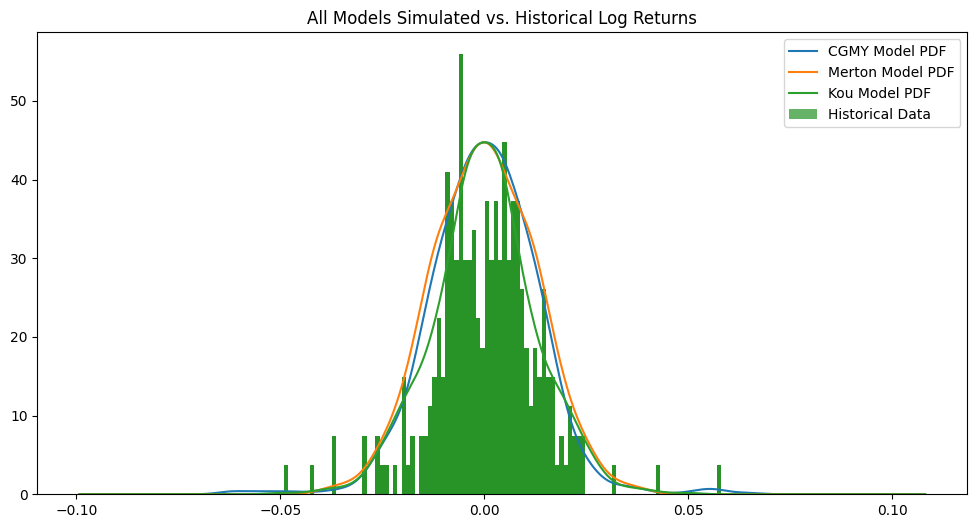

In [25]:
trainer.visualize_all_models()

C:\Users\Bram\AppData\Local\Temp\ipykernel_28728\1403893079.py:156: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Y=GeneticAlgorithm(Kou(0.05, 0.1, 0.01, 0.5, 0.1, 0.1),pd.read_csv("MSFT_option_chain.csv"),np.array([[0.01, np.inf], [0.01, np.inf], [0.01, np.inf], [0.05, 0.95], [0.01, np.inf], [0.01, np.inf]]),40,original_price=yf.Ticker("MSFT").history(period="1d")["Close"][0])


[[-0.13258380053519397, 0.132812826836847, 0.014740370589217934, 0.32854627098788713, 2.8255617719455794, 0.9006382587937078], [-0.16333588516340525, 0.18528298268311177, 0.009067766347804608, 0.4464258356511941, 3.8471839470211266, 1.9300949242634262], [0.32144858243071606, 0.067491516863356, 0.02323750977607575, 0.8496975842365146, 1.0283916388697, 4.101671813744644], [-0.3454887366968423, 0.1605120455280044, 0.0902535380175072, 0.487863275849861, 3.0337172153809213, 0.39030306270529225], [-0.3165647502209501, 0.201859685810105, 0.06690419665890006, 0.9787386138451105, 3.6230492481230647, 4.388840542544247], [0.05110638782298371, 0.26094025232239715, 0.042510204764880793, 0.7486504763186245, 1.0846208759267972, 3.9252310247894866], [0.3458231406719293, 0.26167708230673653, 0.08042614717317564, 0.7844668729517736, 4.918789321610766, 0.9349975327897575], [-0.22025743093657113, 0.21491283307394582, 0.08563740767205458, 0.4372662871558134, 4.561959329112993, 3.688905220591823], [0.282540

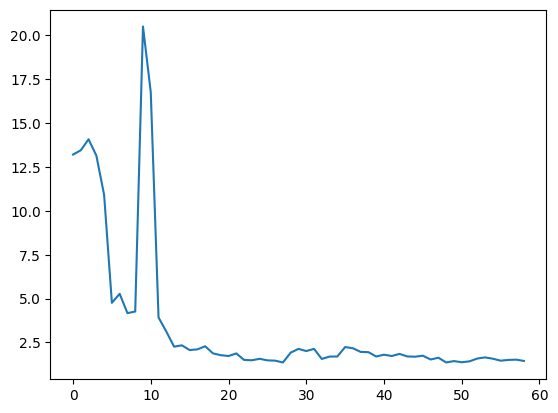

In [45]:
class GeneticAlgorithm():
    def __init__(self,model,price_data,limits,sample_size,beta=0.31,original_price=100):
        self.model=model
        self.price_data=price_data
        self.limits=limits
        self.param_size=len(limits)
        self.sample_size=sample_size
        self.beta=beta
        self.option_pricer=Option_Price_Calculator()
        self.errors=[]
        self.normal_sample_size=self.sample_size ##in order to periodically return to original sample size  
        self.original_price=original_price
    def errorfunc(self,states):
        
        ErrorVector=[]
        for i,l in states.iterrows():
            
            self.model.update_params(l[0:self.param_size])
            error=self.option_pricer.Option_error(self.price_data,self.original_price,2000,self.model,metric="MSE")
            
            ErrorVector.append(error)
        self.errors.append(np.mean(ErrorVector))
        return ErrorVector
    def check_bounds(self,states):
        #states=pd.DataFrame(states)

        return [i.clip(self.limits[:,0],self.limits[:,1]) for i in states]
       
    def initial_states(self,n):
       
        X=[self.model.prior() for _ in range(n)]
        return X
    def mutate(self,states): ##transition kernel considered as a normal distribution with mean stdev of 10% of the parameter value. Size of population should ensure parameters are not blocked on one side of parameter space (with possible positive and negative params for example)
        new_states = np.array(states, copy=True)
    
        # Iterate over each state
        for i, state in enumerate(states):
            # Choose a random parameter index to mutate
            param_index = np.random.randint(0, self.param_size)
            
            # Generate a normal distribution factor with mean and stdev of 10% of the parameter value
            mutation_factor = 1 + 0.16 * np.random.normal()
            
            # Apply the mutation to the chosen parameter
            new_states[i][param_index] = state[param_index] * mutation_factor
        
        return self.check_bounds(new_states)
    def bitwise_crossover(self, states):
        x = np.array(states)
        
        num_parents = x.shape[0]
        offspring = []
        np.random.shuffle(x)
        
        for i in range(num_parents // 2):
            parent1 = x[2 * i]
            parent2 = x[2 * i + 1]

            child1 = parent1.copy()
            child2 = parent2.copy()

            crossover_points = np.random.randint(0, 2, self.param_size).astype(bool)

            child1[crossover_points] = parent2[crossover_points]
            child2[crossover_points] = parent1[crossover_points]

            offspring.append(child1)
            offspring.append(child2)

        return np.array(offspring)
        
    def crossover(self,states):
        x=np.array(states)
       

        s1 = np.random.choice(range(x.shape[0]), int(len(states)//2), replace=False)
        s2 = list(set(range(x.shape[0])) - set(s1))

        # extract your samples:
        sample1 = x[s1,  :]
        sample2 = x[s2,  :]
        
        m=len(s1)
        unif=gen.generate_matrix(m,1).reshape(-1,1)
        unif2=gen.generate_matrix(m,1).reshape(-1,1)
        new_states=np.concatenate([sample1*unif+sample2*(1-unif),sample1*unif2+(1-unif2)*sample2,states],axis=0)
        self.sample_size=len(new_states)
        print("new_size",self.sample_size)
        return new_states
        pass
    
    
    def select(self,states,n): #selection pressure increases as n goes to infinity
        states=pd.DataFrame(states)
        
        errors=self.errorfunc(states)
        print(np.mean(errors))
        states["id"]=states.index
        scaled_errors=-n**self.beta*np.array(errors)
        states["scaled_error"]=np.exp(scaled_errors)
        normal_probs=np.exp(scaled_errors)
        
        selected_=states.loc[gen.generate_matrix(self.sample_size,1).flatten()<=normal_probs]
        
        end=np.zeros(self.sample_size)
        for l,i in selected_.iterrows():
            end[int(i.id)]=int(i.id)
        
        for i,j in states.iterrows():
            if j.id in end:
                pass
            else:
                l=states.copy()
                
               
                l=l[l.id!=j.id]
                sumerror=np.sum(np.exp(l.scaled_error))
                
                l["prob"]=np.exp(l.scaled_error)/sumerror
                l["cumsum"]=np.cumsum(l.prob)
                sample=gen.generate_matrix(1,1)[0]*np.ones(self.sample_size-1)
                selectedid=l[l["cumsum"]>=sample].id.values[0]
                end[i]=selectedid
                
        
        
        
        m=pd.concat([states,pd.DataFrame(end,columns=["selected"])],axis=1)
        
        return self.check_bounds(m.selected.map(lambda x: states.loc[x].values[:-2]))
    def reduce_size(self,states):
        l=pd.DataFrame(states).copy()
        errors=self.errorfunc(l)
        
        l["error"]=errors
        l=l.sort_values("error")
        
        self.sample_size=self.normal_sample_size
        return l.iloc[0:self.normal_sample_size][range(self.param_size)].values
    def run(self,n,m):
        Theta=self.initial_states(n)
        print(Theta)
        for l in range(m):
            print(l)
            #self.beta+=0.2
            Theta=self.mutate(Theta)
            Theta=self.select(Theta,l)
            Theta=self.bitwise_crossover(Theta)
            Theta=self.select(Theta,l)
            if l%3==0:
                Theta=self.reduce_size(Theta)
        plt.plot(self.errors)
        return Theta
# X=GeneticAlgorithm(Merton(0.05, 0.1, 0.01, -0.05, 0.1),pd.read_csv("TSLA_option_chain.csv"),np.array([(0,np.inf),(0,np.inf),(0,np.inf),(-np.inf,np.inf),(0,np.inf)]),10,original_price=yf.Ticker("TSLA").history(period="1d")["Close"][0])
# opt=X.run(10,500)
Y=GeneticAlgorithm(Kou(0.05, 0.1, 0.01, 0.5, 0.1, 0.1),pd.read_csv("MSFT_option_chain.csv"),np.array([[0.01, np.inf], [0.01, np.inf], [0.01, np.inf], [0.05, 0.95], [0.01, np.inf], [0.01, np.inf]]),40,original_price=yf.Ticker("MSFT").history(period="1d")["Close"][0])
opt=Y.run(40,25)


C:\Users\Bram\AppData\Local\Temp\ipykernel_28728\2434858929.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  price=yf.Ticker(selecrted_ticker).history(period="1d")["Close"][0]


           0         1         2         3         4         5    errors
0   0.335877  0.156718  0.011712  0.505766  2.177453  2.367589  1.502433
1   0.335877  0.164468  0.011712  0.473812  3.172311  2.367589  2.164173
2   0.278758  0.160864  0.010000  0.378529  2.710251  2.367589  2.716848
3   0.335877  0.164468  0.011712  0.473812  3.172311  2.367589  2.227569
4   0.335877  0.143782  0.011712  0.473812  3.172311  2.192978  1.368986
5   0.335877  0.143782  0.011712  0.473812  3.172311  2.192978  2.081410
6   0.335877  0.156718  0.011791  0.473812  3.022001  2.098484  2.574770
7   0.278758  0.156718  0.011712  0.473812  2.710251  2.367589  2.066176
8   0.278758  0.160864  0.010000  0.378529  2.710251  2.367589  0.939796
9   0.335877  0.156718  0.011712  0.505766  2.177453  2.367589  1.396716
10  0.278758  0.156718  0.011791  0.473812  2.710251  2.367589  1.940913
11  0.374060  0.156718  0.011712  0.473812  3.793652  2.367589  2.751032
12  0.335877  0.156718  0.011712  0.505766  2.17745

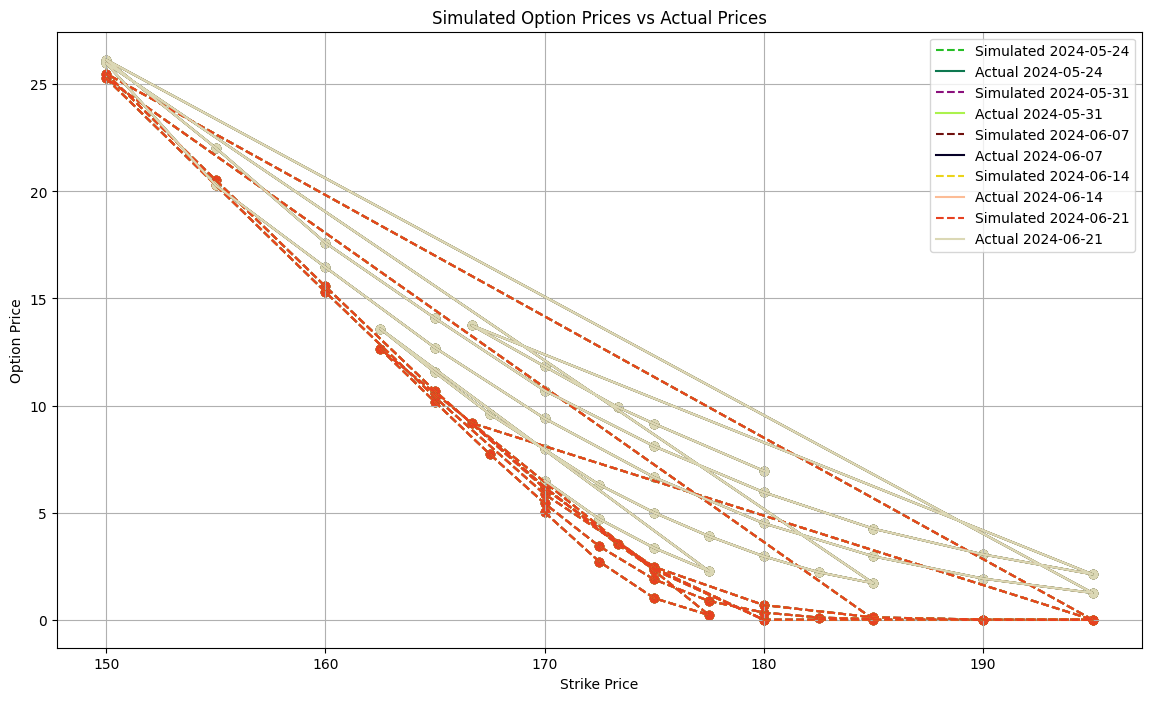

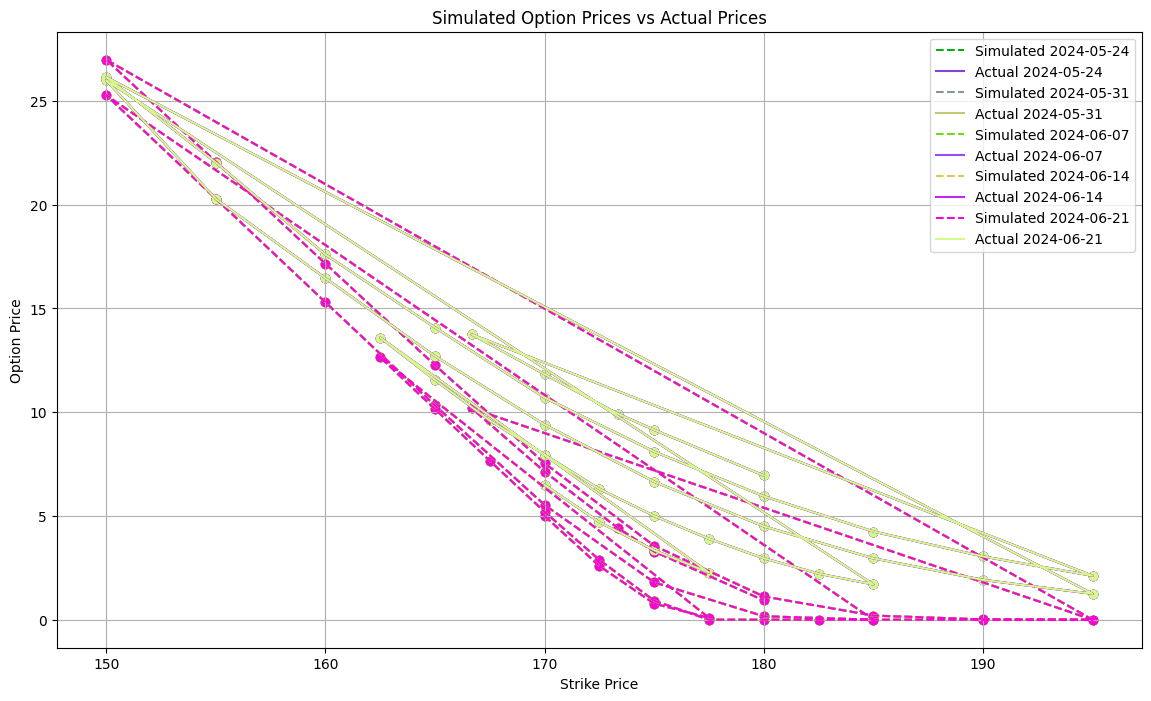

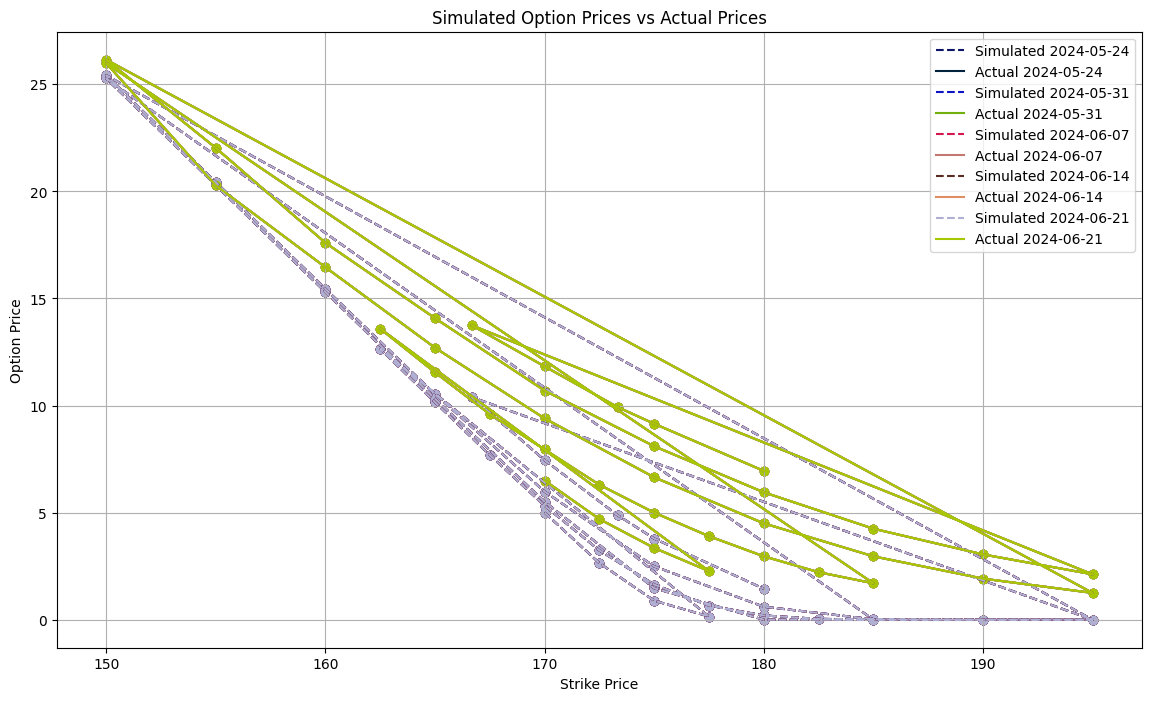

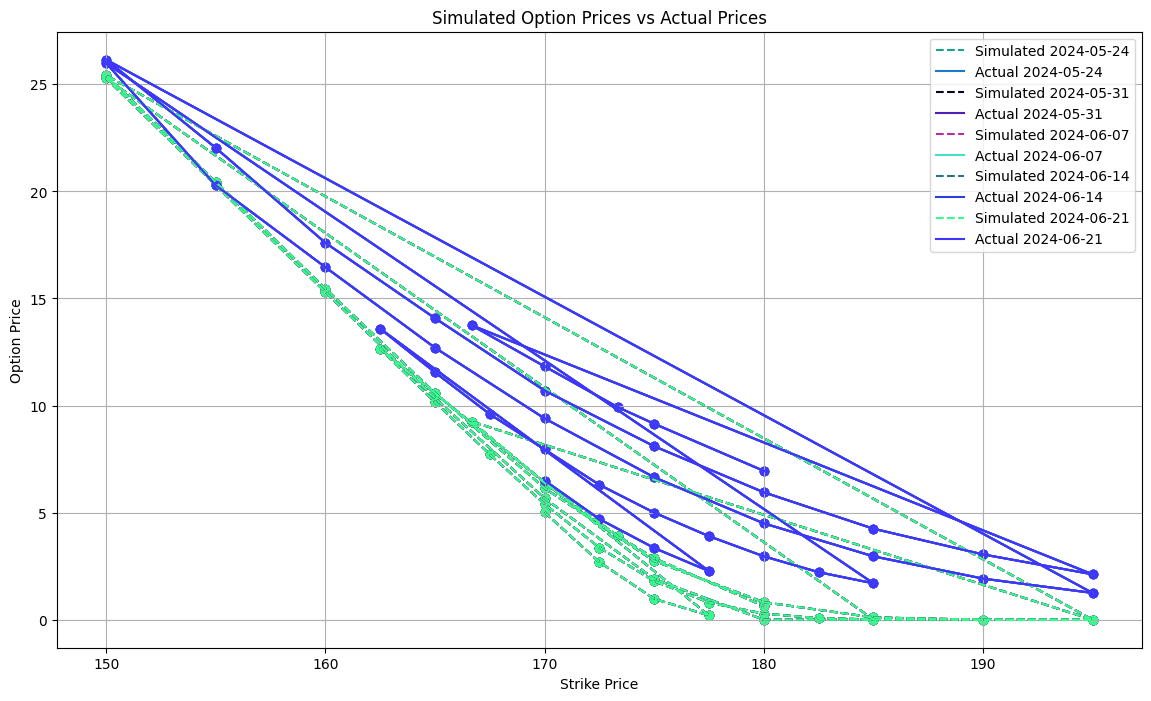

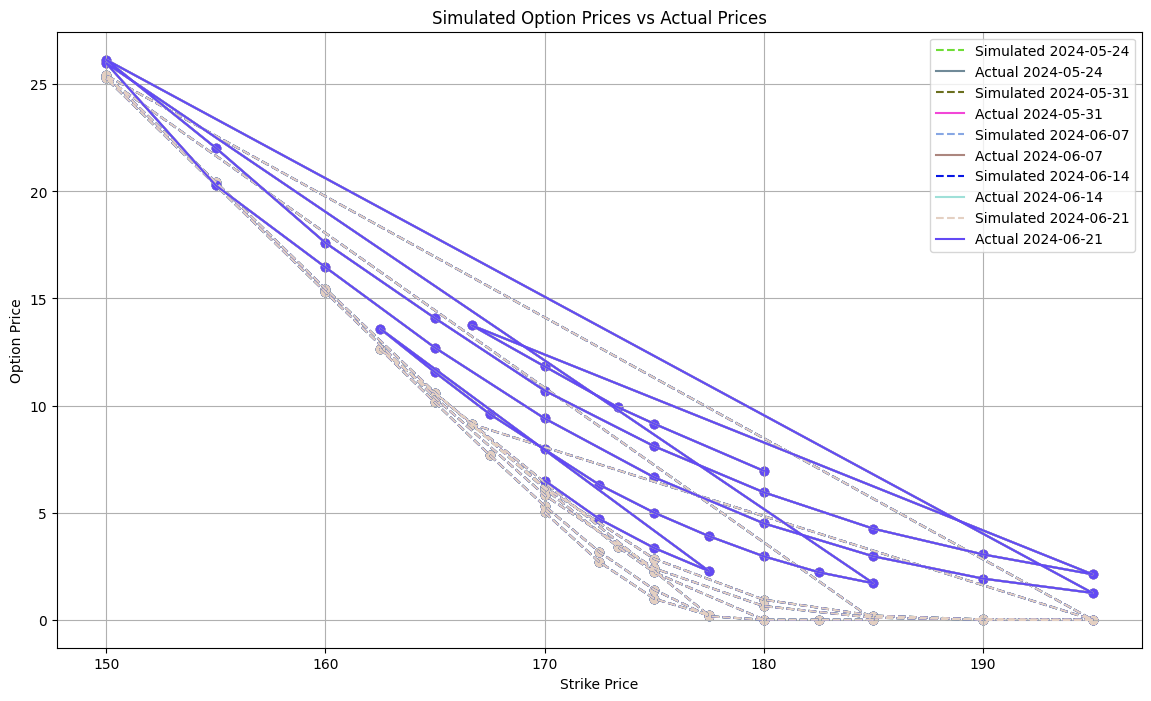

In [41]:
opt
initial_model=Merton(0.05, 0.1, 0.01, -0.05, 0.1)
M=Option_Price_Calculator()
selecrted_ticker="TSLA"
price=yf.Ticker(selecrted_ticker).history(period="1d")["Close"][0]
errors=M.error_vector(pd.read_csv(f"{selecrted_ticker}_option_chain.csv"),price,2000,initial_model)
opt=pd.DataFrame(opt)
opt["errors"]=errors
print(opt)
opt=opt.sort_values("errors")
opt=opt[0:5]
print(opt)
for i,l in  opt.iterrows():
    initial_model.update_params(l[0:5])
    M.plot_option_prices(pd.read_csv("TSLA_option_chain.csv"),price,1000,initial_model)



C:\Users\Bram\AppData\Local\Temp\ipykernel_28728\3159921343.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  price=yf.Ticker(selecrted_ticker).history(period="1d")["Close"][0]


           0         1         2         3         4         5    errors
28  0.010000  0.205084  0.034799  0.402991  4.719043  1.961501  0.542192
37  0.010000  0.205084  0.034799  0.402991  4.401063  2.014748  0.531615
0   0.010000  0.185551  0.034799  0.364528  3.773713  2.014748  0.542593
7   0.010000  0.185551  0.034799  0.364528  3.773713  2.014748  0.746244
36  0.010143  0.205084  0.036354  0.402991  4.719043  1.961501  0.886573
           0         1         2         3         4         5    errors
37  0.010000  0.205084  0.034799  0.402991  4.401063  2.014748  0.531615
28  0.010000  0.205084  0.034799  0.402991  4.719043  1.961501  0.542192
0   0.010000  0.185551  0.034799  0.364528  3.773713  2.014748  0.542593
7   0.010000  0.185551  0.034799  0.364528  3.773713  2.014748  0.746244
36  0.010143  0.205084  0.036354  0.402991  4.719043  1.961501  0.886573


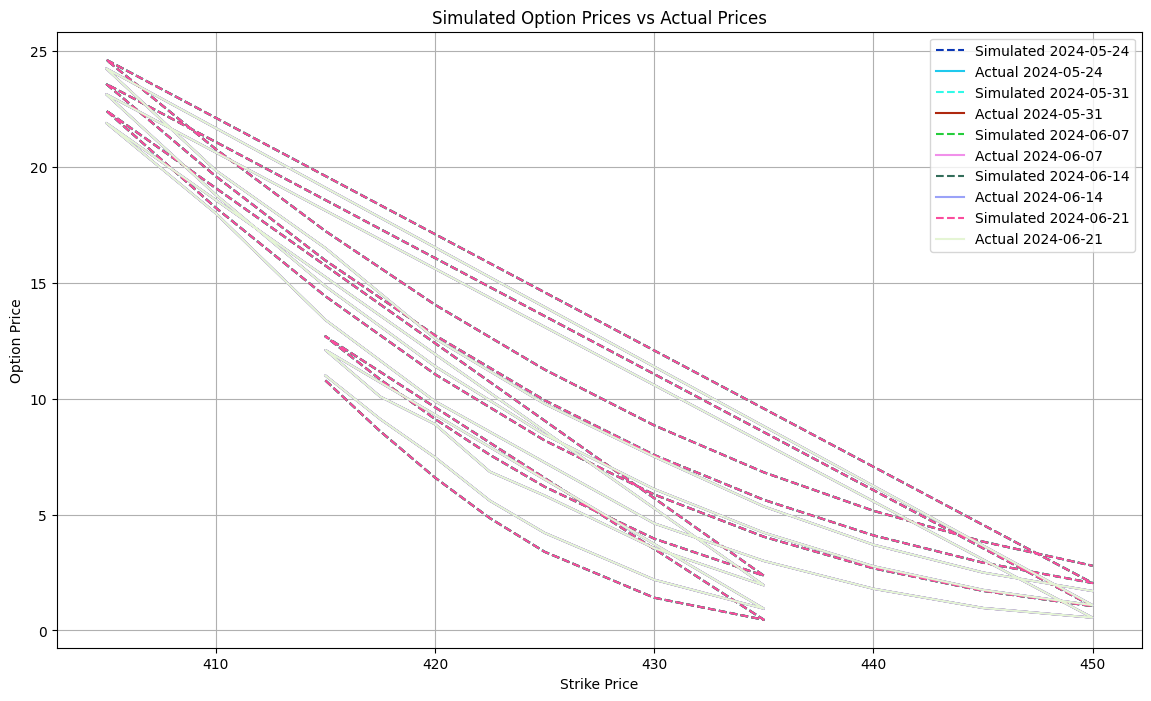

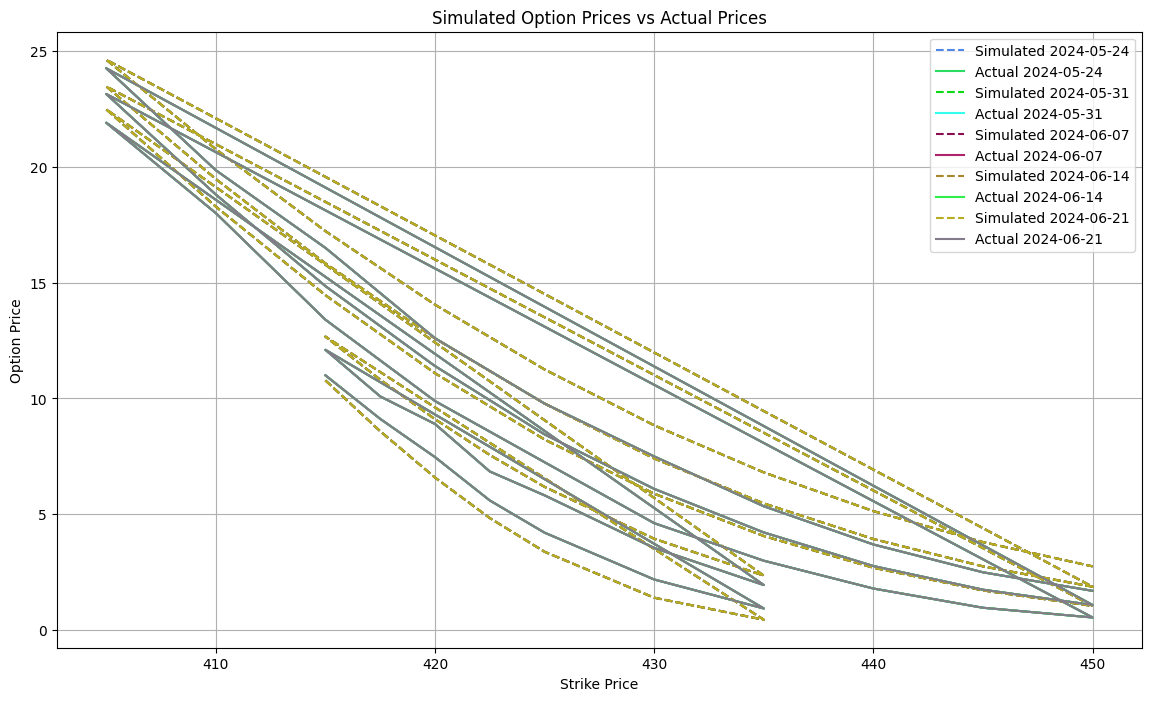

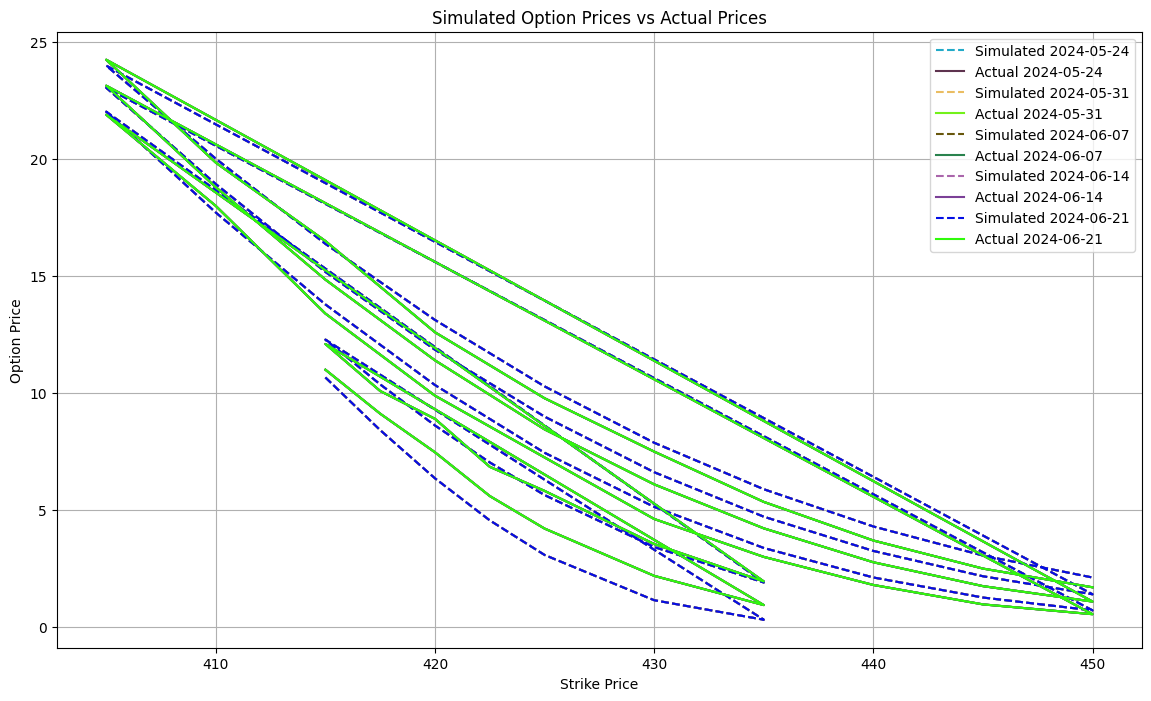

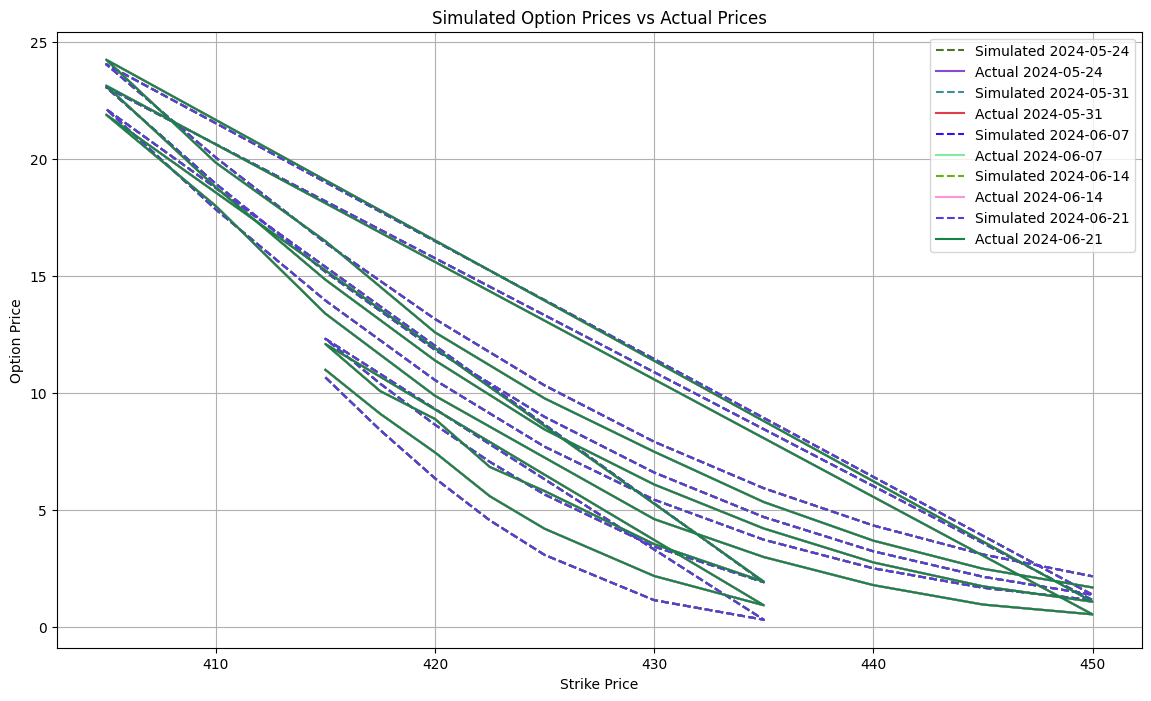

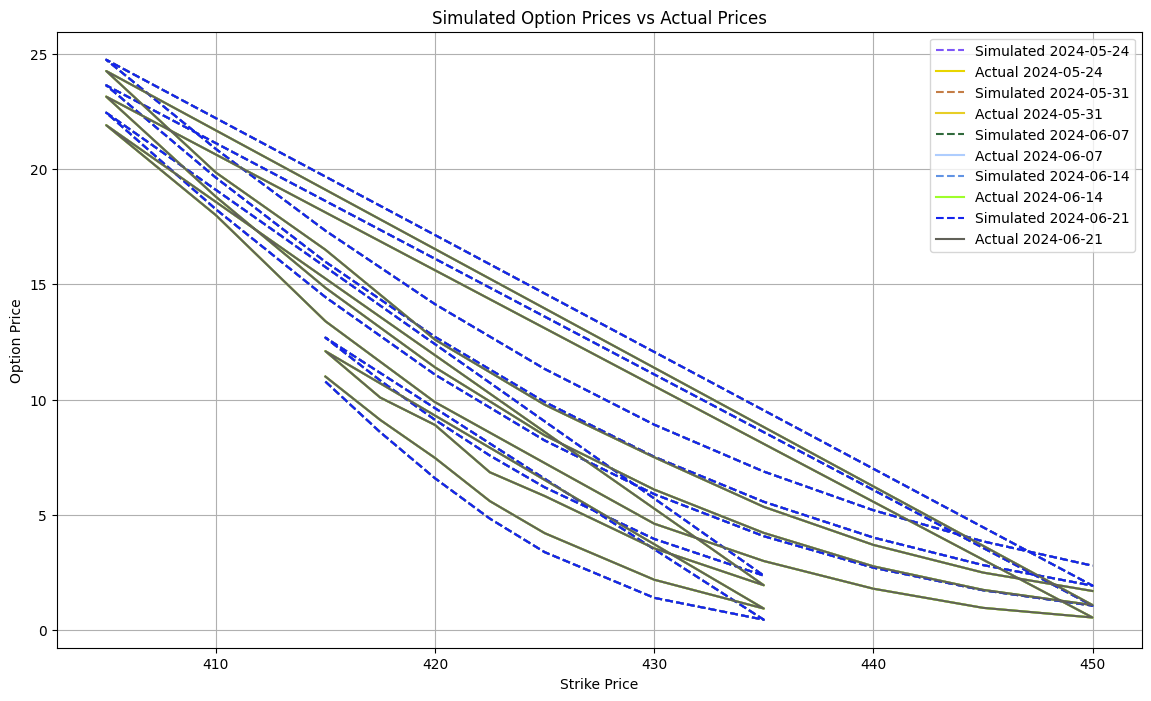

In [51]:
initial_model=Kou(0.05, 0.1, 0.01, 0.5, 0.1, 0.1)
M=Option_Price_Calculator()
selecrted_ticker="MSFT"
price=yf.Ticker(selecrted_ticker).history(period="1d")["Close"][0]
errors=M.error_vector(pd.read_csv(f"{selecrted_ticker}_option_chain.csv"),price,2000,initial_model)
opt=pd.DataFrame(opt)
opt["errors"]=errors
print(opt)
opt=opt.sort_values("errors")
opt=opt[0:5]
print(opt)
for i,l in  opt.iterrows():
    initial_model.update_params(l[0:6])
    M.plot_option_prices(pd.read_csv("MSFT_option_chain.csv"),price,1000,initial_model)



In [29]:
X=[0.010000  ,0.181748  ,0.018891  ,0.950000  ,4.160455  ,8.279854]
L=Kou(*X)
M=Option_Price_Calculator()


In [30]:
errors

0     0.543370
1     1.140487
2     1.882546
3     2.157699
4     2.434513
        ...   
82    3.417891
83    3.644798
84    3.267162
85    2.573401
86    2.275900
Length: 87, dtype: float64